# Advanced Machine Learning - Sunspots Midterm Project
Federico Gritti
D3A



# Task 1: Data Preprocessing and Exploration

## Task 1.1: Import necessary libraries and setup environment

In [1]:
import matplotlib.pyplot as plt
style = 'bmh'
plt.style.use(style)
import matplotlib.colors as mcolors
color1 = 'blue'
color2 = 'red'
color3 = 'green'
color4 = 'orange'

In [2]:
import logging
import warnings
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
use_gpu = True  # Set to True to enable GPU if available
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU at environment level
import logging
logging.getLogger('tensorflow').disabled = True

# Import everything with clean output
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0, alsologtostdout=False)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, LayerNormalization, SimpleRNN, LSTM, Input, TimeDistributed, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Quick GPU status (one line only)
gpu_count = len(tf.config.list_physical_devices('GPU'))
print(f"CUDA_AVAILABLE: {tf.test.is_built_with_cuda()} | TensorFlow {tf.__version__} | GPU Available: {gpu_count > 0} | Logging: SILENT")

# Simple status message
if use_gpu and gpu_count > 0:
    print(f"Using GPU for computations ({gpu_count} GPU(s) detected)")
elif gpu_count > 0:
    print("GPU detected but disabled via CUDA_VISIBLE_DEVICES=-1")
else:
    print("Using CPU for computations (no GPU detected)")

CUDA_AVAILABLE: True | TensorFlow 2.20.0 | GPU Available: True | Logging: SILENT
Using GPU for computations (1 GPU(s) detected)


## Task 1.1.1 Declaring all the functions needed
All the functions are decleared in the next cell for better readability for better readability. Models declaration and training are in the dedicated cells.

In [ ]:
# defining functions 
from tabnanny import verbose


def load_and_inspect_data(path):
    df = pd.read_csv(path)
    print("CHECKING DATASET")
    print("-"*50)
    print(f"Size of the dataset: {df.shape}")
    print("="*50)
    print("PREVIEW:")
    print("-"*50)
    print(df.head())
    print("="*50)
    print("DATASET INFO:")
    print("-"*50)
    print(df.info())
    print("="*50)
    print("STATISTICAL SUMMARY:")
    print("-"*50)
    print(df.describe())
    print("="*50)
    return df

def check_datetime_difference(df, date_col):
    print("CHECKING DATETIME VALIDITY")
    print("-"*50)
    pd.to_datetime(df[date_col], errors='raise') # tries to convert, raises error if invalid
    if pd.to_datetime(df[date_col], errors='coerce').isnull().any():
        print("Invalid dates found.")
    else:       
        print("All dates are valid.")
        
def visualize_trends_and_seasonality(df, value_col, date_col='Month', freq='M'):
    df = df.set_index(date_col)
    df.index = pd.to_datetime(df.index)
    y = df[value_col].asfreq(freq)
    mstl = MSTL(y, periods=(7, 30, 365))
    res = mstl.fit()
    trend = res.trend # extract trend component
    seasonal_month = res.seasonal['seasonal_30'] # extract seasonal component (monthly)
    seasonal_year = res.seasonal['seasonal_365'] # extract seasonal component (yearly)
    resid = res.resid # extract residual component
    fig, axs = plt.subplots(5, 1, figsize=(12, 11), sharex=True)
    axs[0].plot(y, color='steelblue', label='Original')
    axs[1].plot(trend, color='crimson', label='Trend')
    axs[2].plot(seasonal_month, color=color1, label='Seasonal (monthly)')
    axs[3].plot(seasonal_year, color=color2, label='Seasonal (yearly)')
    axs[4].plot(resid, color=color3, label='Residual')
    for ax in axs:
        ax.legend()
        ax.grid(alpha=0.3)
    plt.suptitle('MSTL Decomposition –  Monthly & Yearly Seasonality', fontsize=14)
    plt.tight_layout()
    plt.show()
    
def check_missing_values_for_each_column(df):
    print("CHECKING MISSING VALUES")
    print("-"*50)
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
    print(missing_summary)
    print("="*50)

def outlier_detector(df, n_sigma=3, column=None):
    # this function detects outliers based on the difference between actual and previous value and based on n_sigma standard deviations determines outliers
    if column is None:
        raise ValueError("column must be specified")
    preds = df[column].shift(1)
    err = preds - df[column]
    sigma = err.std() # standard deviation of errors
    candidates = np.argwhere((err.abs() > sigma * n_sigma).values).ravel() # get indices of outliers by using n_sigma rule
    # filter candidates to get only the first in a sequence of outliers
    is_outlier = []
    for i, c in enumerate(candidates):
        if i == 0 or candidates[i - 1] != c - 1: # check if previous candidate is not consecutive
            is_outlier.append(c) # only add if it's the first in a sequence
    is_outlier = np.array(is_outlier)
    print(f"Total {len(is_outlier)} outliers. Percentage: {len(is_outlier)/len(df)*100:.2f}%")
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    err.hist(bins=200, ax=ax[0], color=color1, edgecolor='black')
    ax[0].set_title('Error Distribution')
    ax[0].set_xlabel('Prediction Error')
    ax[0].set_ylabel('Frequency')
    df[column].plot(ax=ax[1], label='Actual Data', alpha=0.7, color=color1)
    preds.plot(ax=ax[1], label='Predictions (shifted)', alpha=0.7, color=color2)
    if len(is_outlier) > 0:
        ax[1].scatter(df.index[is_outlier], df[column].iloc[is_outlier].values, 
                      color='blue', label='Outliers', zorder=5, s=50)
    ax[1].set_title('Data with Outliers Highlighted')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return is_outlier

def split_train_test(df, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)
    print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
    #plot 
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['Month'], train_df['Sunspots'], label='Train', color=color1)
    plt.plot(test_df['Month'], test_df['Sunspots'], label='Test', color=color2)
    plt.title('Train-Test Split')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 x-axis labels to avoid clutter

    plt.xlabel('Month')
    plt.ylabel('Sunspots')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()
    return train_df, test_df

def clean_outliers_with_mean_neighbors(df, outlier_indices, column):
    #this function replaces outliers with the mean of their neighboring values
    df_cleaned = df.copy()
    for idx in outlier_indices:
        if 0 < idx < len(df) - 1:
            df_cleaned.at[idx, column] = (df_cleaned.at[idx - 1, column] + df_cleaned.at[idx + 1, column]) / 2
        elif idx == 0:
            df_cleaned.at[idx, column] = df_cleaned.at[idx + 1, column]
        elif idx == len(df) - 1:
            df_cleaned.at[idx, column] = df_cleaned.at[idx - 1, column]
    print(f"Replaced in total {len(outlier_indices)} outliers. Percentage: {len(outlier_indices)/len(df)*100:.2f}%")
    return df_cleaned

def apply_scaling_and_show(train_df, test_df, method, column):
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif method == 'robust':
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
    elif method  == 'log':
        from sklearn.preprocessing import FunctionTransformer
        scaler = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
    elif method == 'box-cox':
        from sklearn.preprocessing import PowerTransformer
        scaler = PowerTransformer(method='box-cox')
    elif method == 'yeo-johnson':
        from sklearn.preprocessing import PowerTransformer
        scaler = PowerTransformer(method='yeo-johnson')
    else:
        raise ValueError("Unsupported scaling method")
    
    train_values = train_df[[column]].values
    test_values = test_df[[column]].values
    
    scaler.fit(train_values)
    train_scaled = scaler.transform(train_values)
    test_scaled = scaler.transform(test_values)
    
    # Plotting the scaled data
    plt.figure(figsize=(12, 6))
    plt.plot(train_df['Month'], train_scaled, label='Train Scaled', color=color1)
    plt.plot(test_df['Month'], test_scaled, label='Test Scaled', color=color2)
    plt.title(f'{method.capitalize()} Scaled Data')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 x-axis labels

    plt.xlabel('Month')
    plt.ylabel(f'{column} (Scaled)')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()
    #plot also distribution before and after scaling
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_df[column], bins=30, alpha=0.7, color=color1, edgecolor='black', density=True)
    plt.title('Original Train Data Distribution')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.hist(train_scaled, bins=30, alpha=0.7, color=color2, edgecolor='black', density=True)
    plt.title('Scaled Train Data Distribution')
    plt.xlabel(f'{column} (Scaled)')
    plt.ylabel('Density')
    plt.grid()
    plt.tight_layout()
    plt.show()
    print("Initial skewness:", train_df[column].skew())
    print("Scaled skewness:", pd.Series(train_scaled.ravel()).skew())
    
    return train_scaled, test_scaled, scaler

def visualize_data(df):
    # Time Series Plot
    n_of_locators = 10
    plt.figure(figsize=(14, 7))
    plt.plot(df['Month'], df['Sunspots'], label='Sunspots', color=color1)
    plt.title('Monthly Sunspots Time Series')
    plt.xlabel('Month')
    plt.ylabel('Sunspots')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(n_of_locators))
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

    # Rolling Statistics
    rolling_mean = df['Sunspots'].rolling(window=12).mean() # 12-month rolling mean
    rolling_std = df['Sunspots'].rolling(window=12).std() # 12-month rolling std
    plt.figure(figsize=(14, 7))
    plt.plot(df['Month'], df['Sunspots'], label='Original', alpha=0.5)
    plt.plot(df['Month'], rolling_mean, label='Rolling Mean (12 months)', color=color2)
    plt.plot(df['Month'], rolling_std, label='Rolling Std (12 months)', color=color3)
    plt.title('Rolling Statistics')
    plt.xlabel('Month')
    plt.ylabel('Sunspots')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(n_of_locators))
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

    # Histogram and Density Plot
    plt.figure(figsize=(10, 6))
    plt.hist(df['Sunspots'], bins=30, alpha=0.7, color=color1, edgecolor='black', density=True)
    df['Sunspots'].plot(kind='kde', color=color2, linewidth=2)
    plt.title('Distribution of Sunspots')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(n_of_locators))
    plt.xlabel('Sunspots')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
    
def plot_autocorrelation(df, column, lags=50):

    plt.figure(figsize=(12, 6))
    plot_acf(df[column], lags=lags, ax=plt.gca(), color=color1)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(df[column], lags=lags, ax=plt.gca(), color=color2)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()
    
    result = adfuller(df[column].dropna())
    print(f"ADF test for {column}:")
    print("  Test statistic:", result[0])
    print("  p-value:", result[1])
    print("  # lags used:", result[2])
    print("  # observations:", result[3])
    for key, val in result[4].items():
        print(f"    critical {key}:", val)
    print("Conclusion: ", end="")
    if result[1] < 0.05:
        print("Reject the null hypothesis (series is stationary)")
    else:
        print("Fail to reject the null hypothesis (series is non-stationary)")
    print()

def calculate_comprehensive_metrics(y_true, y_pred):
    if hasattr(y_true, 'index') and hasattr(y_pred, 'index'):
        common_index = y_true.index.intersection(y_pred.index)
        if len(common_index) > 0:
            y_true = y_true.loc[common_index]
            y_pred = y_pred.loc[common_index]
    else:
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true.iloc[:min_len] if hasattr(y_true, 'iloc') else y_true[:min_len]
        y_pred = y_pred.iloc[:min_len] if hasattr(y_pred, 'iloc') else y_pred[:min_len]
    
    y_true_np = np.array(y_true).flatten()
    y_pred_np = np.array(y_pred).flatten()
    
    number_of_nans = np.sum(np.isnan(y_true_np)) + np.sum(np.isnan(y_pred_np))
    number_of_infs = np.sum(np.isinf(y_true_np)) + np.sum(np.isinf(y_pred_np))
    if number_of_nans > 0 or number_of_infs > 0:
        print(f"Warning: Found {number_of_nans} NaN values and {number_of_infs} infinite values. These will be ignored in metric calculations.")
    mask = ~(np.isnan(y_true_np) | np.isnan(y_pred_np) | np.isinf(y_true_np) | np.isinf(y_pred_np))
    y_true_clean = y_true_np[mask]
    y_pred_clean = y_pred_np[mask]
    
    if len(y_true_clean) == 0:
        return {metric: np.nan for metric in ['MAE', 'MAPE', 'sMAPE', 'RMSE', 'R2']}
    mae = np.mean(np.abs(y_true_clean - y_pred_clean))
    
    nonzero_mask = y_true_clean != 0
    if np.sum(nonzero_mask) > 0:
        mape = np.mean(np.abs((y_true_clean[nonzero_mask] - y_pred_clean[nonzero_mask]) / y_true_clean[nonzero_mask])) * 100
    else:
        mape = np.nan
    
    denominator = np.abs(y_true_clean) + np.abs(y_pred_clean)
    nonzero_denom = denominator > 0
    if np.sum(nonzero_denom) > 0:
        smape = np.mean(2 * np.abs(y_true_clean[nonzero_denom] - y_pred_clean[nonzero_denom]) / 
                       denominator[nonzero_denom]) * 100
    else:
        smape = np.nan
    
    rmse = np.sqrt(np.mean((y_true_clean - y_pred_clean)**2))
    
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    return {
        'MAE': mae,
        'MAPE': mape,
        'sMAPE': smape,
        'RMSE': rmse,
        'R2': r2
    }

def visualize_predictions(model_paths, X_test, y_test, scaler=None, labels=None, X_train=None, y_train=None, n_train=0, n_test=100):
    if not isinstance(model_paths, list):
        model_paths = [model_paths]  # Allow single path
    
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(model_paths))]
    elif len(labels) != len(model_paths):
        raise ValueError("Number of labels must match number of model paths")
    
    if scaler is not None:
        y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    else:
        y_test_orig = y_test
    y_test_selected = y_test_orig[:n_test]
    if X_train is not None and y_train is not None and n_train > 0:
        if scaler is not None:
            y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        else:
            y_train_orig = y_train
        y_train_selected = y_train_orig[-n_train:]
        y_actual_combined = np.concatenate([y_train_selected, y_test_selected])
        train_test_split_idx = n_train
    else:
        y_actual_combined = y_test_selected
        train_test_split_idx = 0
    plt.figure(figsize=(14, 7))
    plt.plot(y_actual_combined, label='Actual', color=color1, alpha=0.7, linewidth=2)
    model_colors = [color2, color3, color4] + list(mcolors.CSS4_COLORS.keys())[10:10+len(model_paths)]  # Start with predefined, then random
    
    for i, path in enumerate(model_paths):
        model = load_model_from_path(path)
        if model is None:
            continue  # Skip if loading failed
        predictions_combined = []
        if X_train is not None and y_train is not None and n_train > 0:
            predictions_train = model.predict(X_train[-n_train:], verbose=0).flatten()
            if scaler is not None:
                predictions_train_orig = scaler.inverse_transform(predictions_train.reshape(-1, 1)).flatten()
            else:
                predictions_train_orig = predictions_train
            predictions_combined.extend(predictions_train_orig)
        predictions_test = model.predict(X_test[:n_test], verbose=0).flatten()
        if scaler is not None:
            predictions_test_orig = scaler.inverse_transform(predictions_test.reshape(-1, 1)).flatten()
        else:
            predictions_test_orig = predictions_test
        predictions_combined.extend(predictions_test_orig)
        
        plt.plot(predictions_combined, label=labels[i], color=model_colors[i % len(model_colors)], alpha=0.7)
    
    if train_test_split_idx > 0:
        plt.axvline(x=train_test_split_idx - 0.5, color='black', linestyle='--', alpha=0.7, label='Train-Test Split')
    plt.title('Predictions on Train and Test Data (Multiple Models)')
    plt.xlabel('Sample Index')
    plt.ylabel('Sunspots')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def load_model_from_path(model_path, verbose=False):
    try:
        model = tf.keras.models.load_model(model_path)
        if verbose:
            print(f"Model loaded successfully from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None
    

In [ ]:
def create_time_series_split(train_data, test_data, time_steps=12, verbose=False, forecast_horizon=1):
    X_train, y_train = [], []
    
    for i in range(len(train_data) - time_steps - forecast_horizon + 1):
        X_train.append(train_data[i:i + time_steps])
        y_train.append(train_data[i + time_steps : i + time_steps + forecast_horizon])
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test, y_test = [], []
    
    for i in range(len(test_data) - time_steps - forecast_horizon + 1):
        X_test.append(test_data[i:i + time_steps])
        y_test.append(test_data[i + time_steps : i + time_steps + forecast_horizon])
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    if verbose:
        print("Number of training samples:", X_train.shape[0])
        print("Number of test samples:", X_test.shape[0])
        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape)
        print("y_test shape:", y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [ ]:
def compare_model_performance(model_paths_list, model_labels=None, forecast_horizon_list=[1,2,3,4,5,6], colors=None, train_data=None, test_data=None, scaler=None):
    if model_labels is None:
        model_labels = [f'Model {i+1}' for i in range(len(model_paths_list))]
    elif len(model_labels) != len(model_paths_list):
        raise ValueError("Number of labels must match number of model path lists")
    
    if colors is None:
        colors = [color1, color2, color3, color4] + list(mcolors.CSS4_COLORS.keys())[10:10+len(model_paths_list)]
    elif len(colors) != len(model_paths_list):
        raise ValueError("Number of colors must match number of model path lists")
    
    max_time_steps = 0
    for model_paths in model_paths_list:
        for path in model_paths:
            if path is not None:
                parts = path.split('_')
                time_steps = int(parts[-1].split('.')[0][2:])
                max_time_steps = max(max_time_steps, time_steps)
    
    print(f"Using fixed evaluation window with time_steps={max_time_steps} for fair comparison")
    
    model_rmses = []
    model_horizons = []
    
    for model_paths in model_paths_list:
        horizon_rmses = []
        for path in model_paths:
            if path is None:
                horizon_rmses.append(np.nan)
                continue
                
            parts = path.split('_')
            suffix = parts[-3]
            trained_horizon = int(parts[-2][1:])
            model_time_steps = int(parts[-1].split('.')[0][2:])  # Model's original time_steps
            recursive = suffix == 'recursive'
            horizon = trained_horizon
            train_forecast_horizon = 1 if recursive else horizon
            X_train, y_train, X_test, y_test = create_time_series_split(
                train_data, test_data, max_time_steps, verbose=False, 
                forecast_horizon=train_forecast_horizon
            )
            model = load_model_from_path(path)
            if model is None:
                horizon_rmses.append(np.nan)
                continue
            
            if model_time_steps != max_time_steps:
                if model_time_steps < max_time_steps:
                    X_test_adjusted = X_test[:, -model_time_steps:, :]
                else:
                    pad_width = model_time_steps - max_time_steps
                    X_test_adjusted = np.pad(X_test, ((0,0), (pad_width,0), (0,0)), mode='constant')
            else:
                X_test_adjusted = X_test
            
            if recursive:
                n_samples = len(X_test_adjusted) - horizon + 1
                current_batch = X_test_adjusted[:n_samples].copy()
                all_predictions_col = []
                
                for step in range(horizon):
                    step_pred = model.predict(current_batch, verbose=0)
                    all_predictions_col.append(step_pred)
                    current_batch = np.roll(current_batch, -1, axis=1)
                    current_batch[:, -1, 0] = step_pred[:, 0]
                
                predictions_test = np.hstack(all_predictions_col).flatten()
                
                y_test_multistep = []
                for i in range(n_samples):
                    start_idx = max_time_steps + i  # Use max_time_steps consistently
                    end_idx = start_idx + horizon
                    
                    if end_idx <= len(test_data):
                        y_test_multistep.extend(test_data[start_idx:end_idx])
                    else:
                        available = test_data[start_idx:]
                        needed = horizon - len(available)
                        y_test_multistep.extend(available)
                        y_test_multistep.extend([available[-1]] * needed)
                
                y_test_reshaped = np.array(y_test_multistep)
                
            else:
                n_samples = len(X_test_adjusted) - horizon + 1
                X_test_truncated = X_test_adjusted[:n_samples]
                predictions_test = model.predict(X_test_truncated, verbose=0).flatten()
                
                y_test_multistep = []
                for i in range(n_samples):
                    start_idx = max_time_steps + i  # Use max_time_steps consistently
                    end_idx = start_idx + horizon
                    if end_idx <= len(test_data):
                        y_test_multistep.extend(test_data[start_idx:end_idx])
                    else:
                        available = test_data[start_idx:]
                        needed = horizon - len(available)
                        y_test_multistep.extend(available)
                        y_test_multistep.extend([available[-1]] * needed)
                
                y_test_reshaped = np.array(y_test_multistep)
            min_len = min(len(predictions_test), len(y_test_reshaped))
            predictions_test = predictions_test[:min_len]
            y_test_reshaped = y_test_reshaped[:min_len]
            if scaler is not None:
                y_test_orig = scaler.inverse_transform(y_test_reshaped.reshape(-1, 1)).flatten()
                predictions_test_orig = scaler.inverse_transform(predictions_test.reshape(-1, 1)).flatten()
                rmse = calculate_comprehensive_metrics(y_test_orig, predictions_test_orig)['RMSE']
            else:
                rmse = calculate_comprehensive_metrics(y_test_reshaped, predictions_test)['RMSE']
            
            horizon_rmses.append(rmse)
            
            del model
            tf.keras.backend.clear_session()
        
        model_rmses.append(horizon_rmses)
        model_horizons.append([int(path.split('_')[-2][1:]) if path else np.nan for path in model_paths])
    
    plt.figure(figsize=(12, 7))
    for i, (rmses, horizons, label) in enumerate(zip(model_rmses, model_horizons, model_labels)):
        valid_horizons = []
        valid_rmses = []
        for h, r in zip(horizons, rmses):
            if not np.isnan(r):
                valid_horizons.append(h)
                valid_rmses.append(r)
        if valid_horizons:
            plt.plot(valid_horizons, valid_rmses, marker='o', linewidth=2, 
                    color=colors[i % len(colors)], label=label, markersize=8)
    
    plt.title('Model Performance Comparison: RMSE vs Trained Forecast Horizon (Fair Evaluation)', fontsize=16)
    plt.xlabel('Trained Forecast Horizon (steps ahead)', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(forecast_horizon_list)
    plt.tight_layout()
    plt.show()
    
    # Same leaderboard code as before...
    print(f"\nModel Performance Leaderboards (Fair Evaluation - All models tested on same window starting from index {max_time_steps}):")
    print("=" * 100)
    
    leaderboards = []
    for h_idx, horizon in enumerate(forecast_horizon_list):
        leaderboard_lines = []
        leaderboard_lines.append(f"Leaderboard for Forecast Horizon {horizon}:")
        leaderboard_lines.append("-" * 50)
        leaderboard_lines.append(f"{'Rank':<5} {'Model':<25} {'RMSE':<12}")
        leaderboard_lines.append("-" * 50)
        
        horizon_scores = []
        for i, (rmses, label) in enumerate(zip(model_rmses, model_labels)):
            if h_idx < len(rmses) and not np.isnan(rmses[h_idx]):
                horizon_scores.append((rmses[h_idx], label))
        
        horizon_scores.sort(key=lambda x: x[0])
        
        for rank, (rmse, label) in enumerate(horizon_scores, start=1):
            leaderboard_lines.append(f"{rank:<5} {label:<25} {rmse:<12.4f}")
        leaderboard_lines.append("-" * 50)
        
        leaderboards.append(leaderboard_lines)
    
    max_line_lens = [max(len(line) for line in lb) for lb in leaderboards]
    num_cols = 2
    for row_start in range(0, len(leaderboards), num_cols):
        row_leaderboards = leaderboards[row_start:row_start + num_cols]
        row_max_lens = max_line_lens[row_start:row_start + num_cols]
        max_lines_row = max(len(lb) for lb in row_leaderboards)
        for i in range(max_lines_row):
            line_parts = []
            for j, lb in enumerate(row_leaderboards):
                if i < len(lb):
                    line_parts.append(lb[i].ljust(row_max_lens[j]))
                else:
                    line_parts.append("".ljust(row_max_lens[j]))
            print("  ".join(line_parts))
        print()



The function **compare_model_performance** loads and evaluates multiple models on a fixed time series window for fair comparison. It adjusts input sequences to match each model's expected time steps, handles recursive and direct forecasting, and computes RMSE for each horizon. Results are visualized with bar plots for easy comparison across models and horizons.

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
import os
import tensorflow as tf
import gc

def rolling_forecast_evaluation_multiple_steps(train_data, test_data, time_steps_list, model_builder, param_list, scaler=None, forecast_horizon_list=[1,2,3,4,5,6], recursive=False, base_name=None, verbose=False):
    all_results = []
    all_histories = []
    all_model_names = []
    all_input_shapes = []
    all_configurations = []
    all_train_results = []
    
    horizon_best_configs = {}  # To store best config for each horizon
    horizon_best_paths = {}    # To store best path for each horizon
    
    for forecast_horizon in forecast_horizon_list:
        horizon_results = []  # Collect results for this horizon
        horizon_train_results = []
        horizon_configs = []
        horizon_names = []
        horizon_input_shapes = []
        horizon_histories = []
        
        for time_steps in time_steps_list:
            # For recursive, train on single-step; for direct, train on multi-step
            train_forecast_horizon = 1 if recursive else forecast_horizon
            X_train, y_train, X_test, y_test = create_time_series_split(train_data, test_data, time_steps, verbose=False, forecast_horizon=train_forecast_horizon)
            input_shape = (X_train.shape[1], X_train.shape[2])
            
            for i, params in enumerate(param_list):
                model_params = {k: v for k, v in params.items() if k not in ['epochs', 'batch_size', 'output_units']}
                output_units = 1 if recursive else forecast_horizon
                model = model_builder(input_shape, output_units=output_units, **model_params)
                
                epochs = params.get('epochs', 50)
                batch_size = params.get('batch_size', 32)
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                    validation_split=0.1, callbacks=[early_stopping], verbose=0)
                
                sample_pred = model.predict(X_train[:1], verbose=0)
                expected_shape = (1, output_units)
                if sample_pred.shape != expected_shape:
                    print(f"Warning: Shape mismatch for {'recursive' if recursive else 'direct'} forecasting.")
                
                # Training metrics
                predictions_train = model.predict(X_train, verbose=0).flatten()
                y_train_reshaped = y_train.flatten()
                if scaler is not None:
                    y_train_orig = scaler.inverse_transform(y_train_reshaped.reshape(-1, 1)).flatten()
                    predictions_train_orig = scaler.inverse_transform(predictions_train.reshape(-1, 1)).flatten()
                    train_metrics = calculate_comprehensive_metrics(y_train_orig, predictions_train_orig)
                else:
                    train_metrics = calculate_comprehensive_metrics(y_train_reshaped, predictions_train)
                if recursive:
                    n_samples = len(X_test) - forecast_horizon + 1
                    current_batch = X_test[:n_samples].copy()
                    all_predictions_col = []
                    
                    # Generate predictions
                    for step in range(forecast_horizon):
                        step_pred = model.predict(current_batch, verbose=0)
                        all_predictions_col.append(step_pred)
                        current_batch = np.roll(current_batch, -1, axis=1)
                        current_batch[:, -1, 0] = step_pred[:, 0]
                    
                    predictions_test = np.hstack(all_predictions_col).flatten()
                    
                    y_test_multistep = []
                    for i in range(n_samples):
                        # Calculate position in original test_data
                        start_idx = time_steps + i
                        end_idx = start_idx + forecast_horizon
                        
                        if end_idx <= len(test_data):
                            y_test_multistep.extend(test_data[start_idx:end_idx])
                        else:
                            # Handle edge case - pad with last available values
                            available = test_data[start_idx:]
                            needed = forecast_horizon - len(available)
                            y_test_multistep.extend(available)
                            y_test_multistep.extend([available[-1]] * needed)
                    
                    y_test_reshaped = np.array(y_test_multistep)
                    
                else:
                    n_samples = len(X_test) - forecast_horizon + 1
                    X_test_truncated = X_test[:n_samples]
                    predictions_test = model.predict(X_test_truncated, verbose=0).flatten()
                    y_test_multistep = []
                    for i in range(n_samples):
                        start_idx = time_steps + i
                        end_idx = start_idx + forecast_horizon
                        if end_idx <= len(test_data):
                            y_test_multistep.extend(test_data[start_idx:end_idx])
                        else:
                            available = test_data[start_idx:]
                            needed = forecast_horizon - len(available)
                            y_test_multistep.extend(available)
                            y_test_multistep.extend([available[-1]] * needed)
                    
                    y_test_reshaped = np.array(y_test_multistep)
                
                if verbose:
                    print(f"Debug - Forecast horizon: {forecast_horizon}, Recursive: {recursive}")
                    print(f"Predictions shape: {predictions_test.shape}")
                    print(f"Ground truth shape: {y_test_reshaped.shape}")
                    print(f"Samples evaluated: {len(predictions_test) // forecast_horizon}")
                    
                min_len = min(len(predictions_test), len(y_test_reshaped))
                predictions_test = predictions_test[:min_len]
                y_test_reshaped = y_test_reshaped[:min_len]
                                
                if scaler is not None:
                    y_test_orig = scaler.inverse_transform(y_test_reshaped.reshape(-1, 1)).flatten()
                    predictions_test_orig = scaler.inverse_transform(predictions_test.reshape(-1, 1)).flatten()
                    metrics = calculate_comprehensive_metrics(y_test_orig, predictions_test_orig)
                else:
                    metrics = calculate_comprehensive_metrics(y_test_reshaped, predictions_test)
                
                print("="*80)
                print(f"Forecast Horizon: {forecast_horizon}, Time Steps: {time_steps}, Recursive: {recursive}")
                print(f"Model Params: {params}")
                print(f"Train RMSE: {train_metrics['RMSE']:.4f}, Test RMSE: {metrics['RMSE']:.4f}")
                
                config = {
                    'forecast_horizon': forecast_horizon,
                    'time_steps': time_steps,
                    'model_params': params,
                    'input_shape': input_shape,
                    'recursive': recursive,
                    'model_index': i + 1,
                    'train_rmse': train_metrics['RMSE'],
                    'test_rmse': metrics['RMSE']
                }
                horizon_results.append(metrics)
                horizon_train_results.append(train_metrics)
                horizon_histories.append(history.history)
                horizon_names.append(f"Forecast_horizon {forecast_horizon}, Time_steps {time_steps}, Model {i+1}: {params}, Recursive: {recursive}")
                horizon_input_shapes.append(input_shape)
                horizon_configs.append(config)

                tf.keras.backend.clear_session()
                gc.collect()
                del model
                del history
        
        if horizon_results:
            sorted_indices = sorted(range(len(horizon_results)), key=lambda i: horizon_results[i]['RMSE'])
            best_idx = sorted_indices[0]
            best_config = horizon_configs[best_idx]
            
            # Rebuild and retrain the best model for this horizon
            best_model = model_builder(
                best_config['input_shape'], 
                output_units=1 if best_config['recursive'] else best_config['forecast_horizon'],
                **{k: v for k, v in best_config['model_params'].items() if k not in ['epochs', 'batch_size', 'output_units']}
            )
            
            # Retrain
            X_train_best, y_train_best, _, _ = create_time_series_split(
                train_data, test_data, 
                best_config['time_steps'], 
                forecast_horizon=1 if best_config['recursive'] else best_config['forecast_horizon'],
            )
            
            best_epochs = best_config['model_params'].get('epochs', 50)
            best_batch_size = best_config['model_params'].get('batch_size', 32)
            best_model.fit(X_train_best, y_train_best, epochs=best_epochs, batch_size=best_batch_size, 
                           validation_split=0.1, verbose=0)
            
            if base_name is None:
                base_name = "model"
            suffix = "recursive" if recursive else "direct"
            horizon = best_config['forecast_horizon']
            time_steps = best_config['time_steps']
            model_save_path = f"./models/best_{base_name}_{suffix}_H{horizon}_TS{time_steps}.keras" 
            best_model.save(model_save_path)
            print(f"Best model for horizon {horizon} saved to: {model_save_path}")
            
            horizon_best_configs[forecast_horizon] = best_config
            horizon_best_paths[forecast_horizon] = model_save_path
            del best_model
            tf.keras.backend.clear_session()
            gc.collect()
        
        all_results.extend(horizon_results)
        all_train_results.extend(horizon_train_results)
        all_histories.extend(horizon_histories)
        all_model_names.extend(horizon_names)
        all_input_shapes.extend(horizon_input_shapes)
        all_configurations.extend(horizon_configs)
    
    from collections import defaultdict
    horizon_results_rmse_train = defaultdict(list)
    horizon_results_rmse_test = defaultdict(list)
    for i, name in enumerate(all_model_names):
        horizon = int(name.split(',')[0].split()[1])
        horizon_results_rmse_train[horizon].append(all_train_results[i]['RMSE'])
        horizon_results_rmse_test[horizon].append(all_results[i]['RMSE'])
    
    print("\nComparison of Forecast Horizons (Train RMSE):")
    horizons = sorted(horizon_results_rmse_train)
    mean_rmses_train = []
    for horizon in horizons:
        rmses = horizon_results_rmse_train[horizon]
        mean_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        mean_rmses_train.append(mean_rmse)
        print(f"  Horizon {horizon}: Mean Train RMSE {mean_rmse:.4f}, Std Train RMSE {std_rmse:.4f}")
    
    print("\nComparison of Forecast Horizons (Test RMSE):")
    mean_rmses_test = []
    for horizon in horizons:
        rmses = horizon_results_rmse_test[horizon]
        mean_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        mean_rmses_test.append(mean_rmse)
        print(f"  Horizon {horizon}: Mean Test RMSE {mean_rmse:.4f}, Std Test RMSE {std_rmse:.4f}")
    plt.figure(figsize=(14, 8))
    box_data_combined = []
    box_labels_combined = []
    colors_combined = []
    train_color = 'blue'
    test_color = 'red'
    


    for horizon in horizons:
        # Add train data
        rmses_train = horizon_results_rmse_train[horizon]
        if rmses_train:
            box_data_combined.append(rmses_train)
            box_labels_combined.append(f'H{horizon} Train')
            colors_combined.append(train_color)
        rmses_test = horizon_results_rmse_test[horizon]
        if rmses_test:
            box_data_combined.append(rmses_test)
            box_labels_combined.append(f'H{horizon} Test')
            colors_combined.append(test_color)
    box_plot_combined = plt.boxplot(box_data_combined, tick_labels=box_labels_combined, patch_artist=True)
    for patch, color in zip(box_plot_combined['boxes'], colors_combined):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    title_suffix = 'Recursive' if recursive else 'Direct'
    plt.title(f'Train and Test RMSE Distribution by Forecast Horizon ({title_suffix})', fontsize=16)
    plt.xlabel('Forecast Horizon and Dataset', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.grid(alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    for i, (label, data) in enumerate(zip(box_labels_combined, box_data_combined)):
        if data:
            mean_val = np.mean(data)
            color = train_color if 'Train' in label else test_color
            plt.plot(i + 1, mean_val, 'o', color=color, markersize=8, markeredgecolor='black')
    train_means = []
    train_positions = []
    for i, (label, data) in enumerate(zip(box_labels_combined, box_data_combined)):
        if 'Train' in label and data:
            train_means.append(np.mean(data))
            train_positions.append(i + 1)
    if train_means:
        plt.plot(train_positions, train_means, color=train_color, linestyle='-', linewidth=2)
    
    # Connect test means with a line
    test_means = []
    test_positions = []
    for i, (label, data) in enumerate(zip(box_labels_combined, box_data_combined)):
        if 'Test' in label and data:
            test_means.append(np.mean(data))
            test_positions.append(i + 1)
    if test_means:
        plt.plot(test_positions, test_means, color=test_color, linestyle='-', linewidth=2)
    
    # Add legend
    train_patch = plt.Rectangle((0,0),1,1,fc=train_color, alpha=0.7)
    test_patch = plt.Rectangle((0,0),1,1,fc=test_color, alpha=0.7)
    plt.legend([train_patch, test_patch], ['Train', 'Test'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    time_steps_results_rmse_test = defaultdict(list)
    for i, name in enumerate(all_model_names):
        time_steps = int(name.split(',')[1].split()[1])
        time_steps_results_rmse_test[time_steps].append(all_results[i]['RMSE'])
    print("\nComparison of Time Steps (Test RMSE):")
    time_steps_sorted = sorted(time_steps_results_rmse_test)
    for ts in time_steps_sorted:
        rmses = time_steps_results_rmse_test[ts]
        mean_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        print(f"  Time Steps {ts}: Mean Test RMSE {mean_rmse:.4f}, Std Test RMSE {std_rmse:.4f}")
    plt.figure(figsize=(12, 7))
    box_data_ts = []
    box_labels_ts = []
    for ts in time_steps_sorted:
        rmses = time_steps_results_rmse_test[ts]
        if rmses:
            box_data_ts.append(rmses)
            box_labels_ts.append(f'TS{ts}')
    box_plot_ts = plt.boxplot(box_data_ts, tick_labels=box_labels_ts, patch_artist=True)
    for patch in box_plot_ts['boxes']:
        patch.set_facecolor(test_color)
        patch.set_alpha(0.7)

    

    plt.title(f'Test RMSE Distribution by Time Steps ({title_suffix})', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.grid(alpha=0.3, axis='y')
    
    for i, data in enumerate(box_data_ts):
        if data:
            mean_val = np.mean(data)
            plt.plot(i + 1, mean_val, 'o', color=test_color, markersize=8, markeredgecolor='black')
    
    means = []
    positions = []
    for i, data in enumerate(box_data_ts):
        if data:
            means.append(np.mean(data))
            positions.append(i + 1)
    if means:
        plt.plot(positions, means, color=test_color, linestyle='-', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    best_model_paths = [horizon_best_paths[h] for h in forecast_horizon_list]
    best_model_names = [f"Best for H{h}" for h in forecast_horizon_list]
    best_configurations = [horizon_best_configs[h] for h in forecast_horizon_list]
    horizon_best = {}
    for h in forecast_horizon_list:
        if h in horizon_best_configs:
            config = horizon_best_configs[h]
            rmse_test = config['test_rmse']
            rmse_train = config['train_rmse']
            horizon_best[h] = (rmse_test, f"Best for H{h}", rmse_train)

    print("\nBest Model per Horizon:")
    print("-" * 50)
    for h in sorted(horizon_best):
        r_test, label, r_train = horizon_best[h]
        print(f"Horizon {h}: {label} with Train RMSE {r_train:.4f}, Test RMSE {r_test:.4f}")
    print("-" * 50)
    comprehensive_results = {
        'best_model_paths': best_model_paths,
        'best_model_names': best_model_names,
        'best_configurations': best_configurations,
    }
    del all_results, all_histories, all_model_names, all_input_shapes, all_configurations, all_train_results
    del horizon_results, horizon_train_results, horizon_histories, horizon_names, horizon_input_shapes, horizon_configs
    del horizon_best_configs, horizon_best_paths
    gc.collect()

    return comprehensive_results

The function **rolling_forecast_evaluation_multiple_steps** above provides an end-to-end implementation for rolling forecast 
evaluation with multiple steps ahead forecasting, including model training,evaluation, saving best models, and visualizing performance across different forecast horizons and time steps. Moreover, it optimizes the recursive forecasting logic by vectorizing the prediction 
process to significantly reduce computation time by exploiting batch predictions instead of sequentially predicting each time step for each sample which was taking too long

---

## Task 1.2: Loading and inspecting the dataset

### Task 1.2.1: Load and inspect basic dataset properties

In [7]:
df = load_and_inspect_data('sunspots.csv')


CHECKING DATASET
--------------------------------------------------
Size of the dataset: (2820, 2)
PREVIEW:
--------------------------------------------------
     Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0
DATASET INFO:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB
None
STATISTICAL SUMMARY:
--------------------------------------------------
          Sunspots
count  2820.000000
mean     51.265957
std      43.448971
min       0.000000
25%      15.700000
50%      42.000000
75%      74.925000
max     253.800000


The dataset contains monthly sunspot numbers from January 1749 to December 2023 and no abnormalities were found.

In [8]:
check_datetime_difference(df, 'Month')

CHECKING DATETIME VALIDITY
--------------------------------------------------
All dates are valid.


All dates are in order and there are no missing values.

### Task 1.2.2: Check datetime validity and format

In [9]:
check_missing_values_for_each_column(df)

CHECKING MISSING VALUES
--------------------------------------------------
          Missing Values  Percentage (%)
Month                  0             0.0
Sunspots               0             0.0


No missing data found in the dataset

### Task 1.2.3: Check for missing values

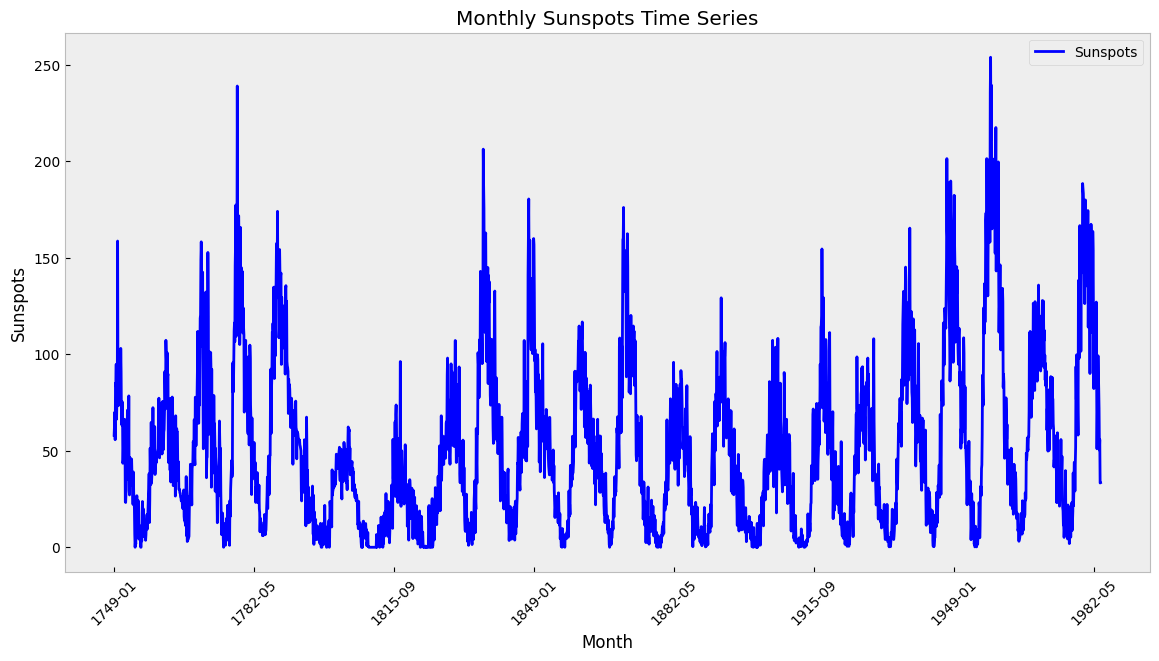

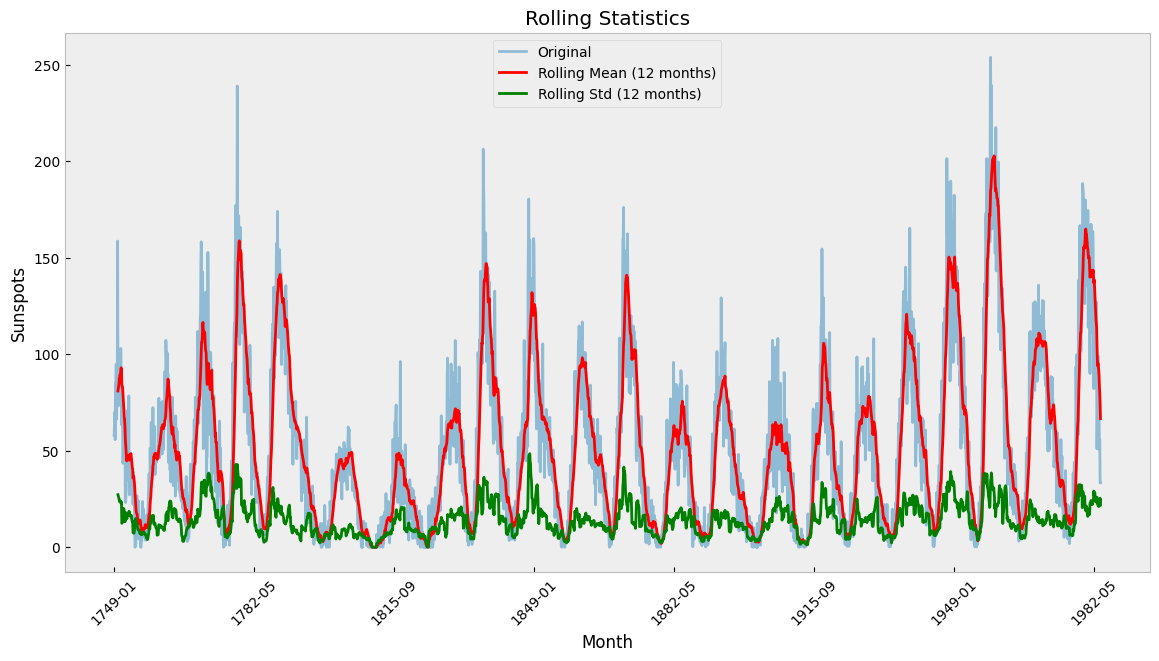

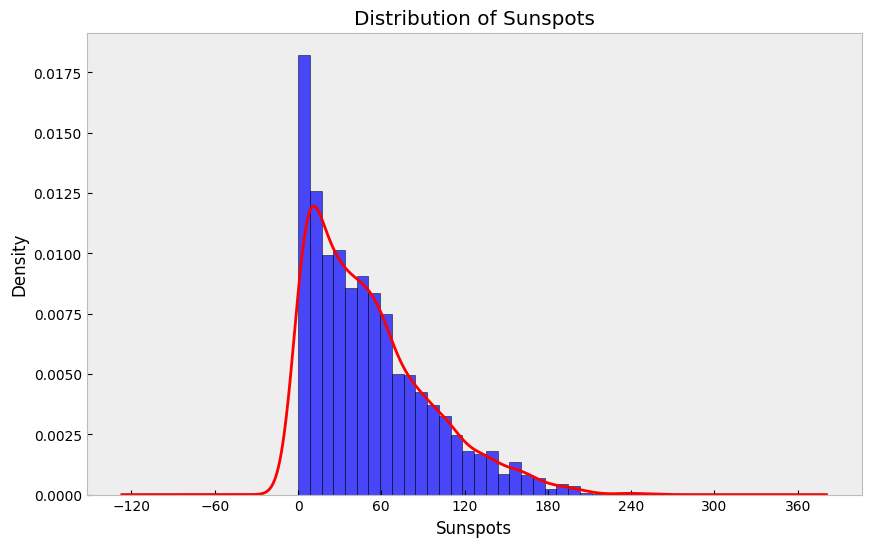

In [10]:
visualize_data(df)

The distribution of sunspot numbers appears to be right-skewed, with a long tail towards higher values. Most sunspot numbers are concentrated at the lower end of the scale, with fewer occurrences of high sunspot numbers. So we apply a transformation to reduce skewness. Moreover the data shows clear cyclical patterns, with peaks and troughs occurring at regular intervals, indicating periodic increases and decreases in sunspot activity over time.

### Task 1.2.4: Visualize time series data and basic statistics

The function below counts outliers by checking the differeence between the actual value and the previous value. If the difference is greater than a certain threshold (set to 3 standard deviations of the differences), the point is considered an outlier.

Total 31 outliers. Percentage: 1.10%


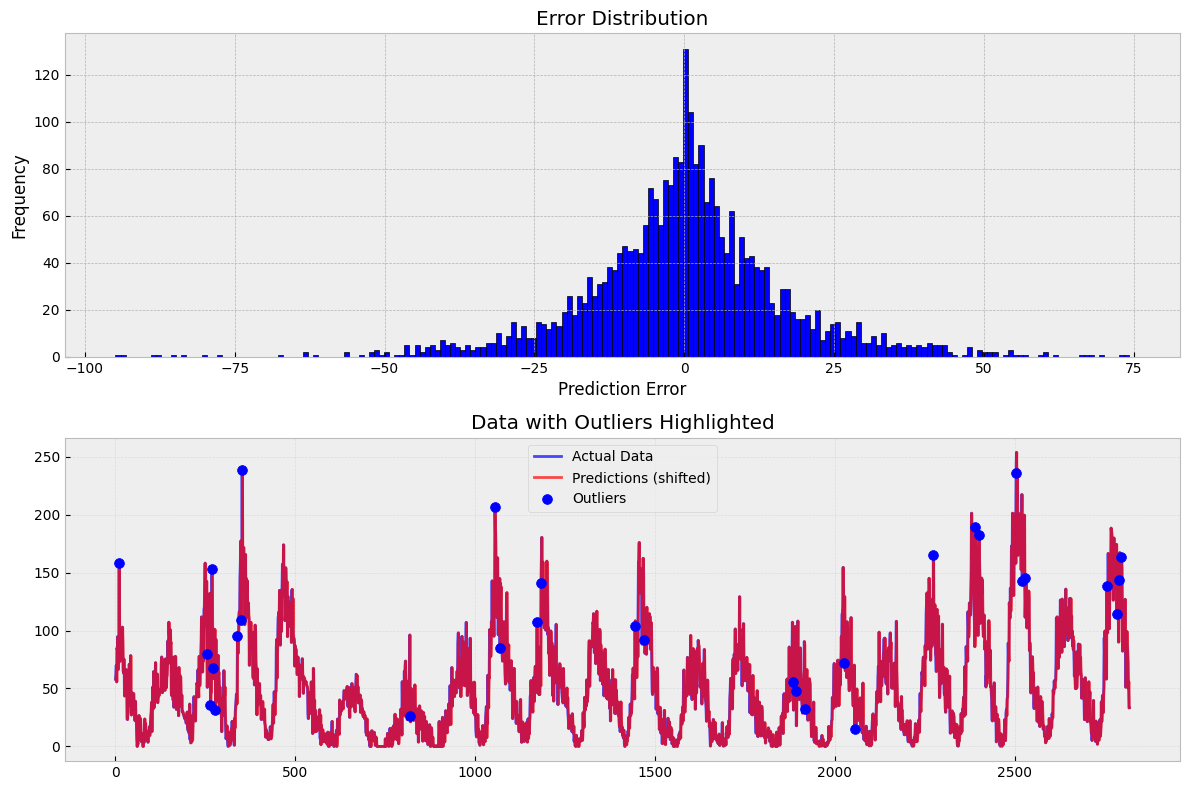

In [11]:
outliers_indices = outlier_detector(df, column='Sunspots')

The dataset contains some outliers as shown in the plot.

### Task 1.2.5: Detect and analyze outliers

In [12]:
df_cleaned = clean_outliers_with_mean_neighbors(df, outliers_indices, column='Sunspots')


Replaced in total 31 outliers. Percentage: 1.10%


The outliers are not so many but they were handled using the mean neighborhood imputation during the preprocessing step.

### Task 1.2.6: Clean outliers and verify cleaning

Total 15 outliers. Percentage: 0.53%


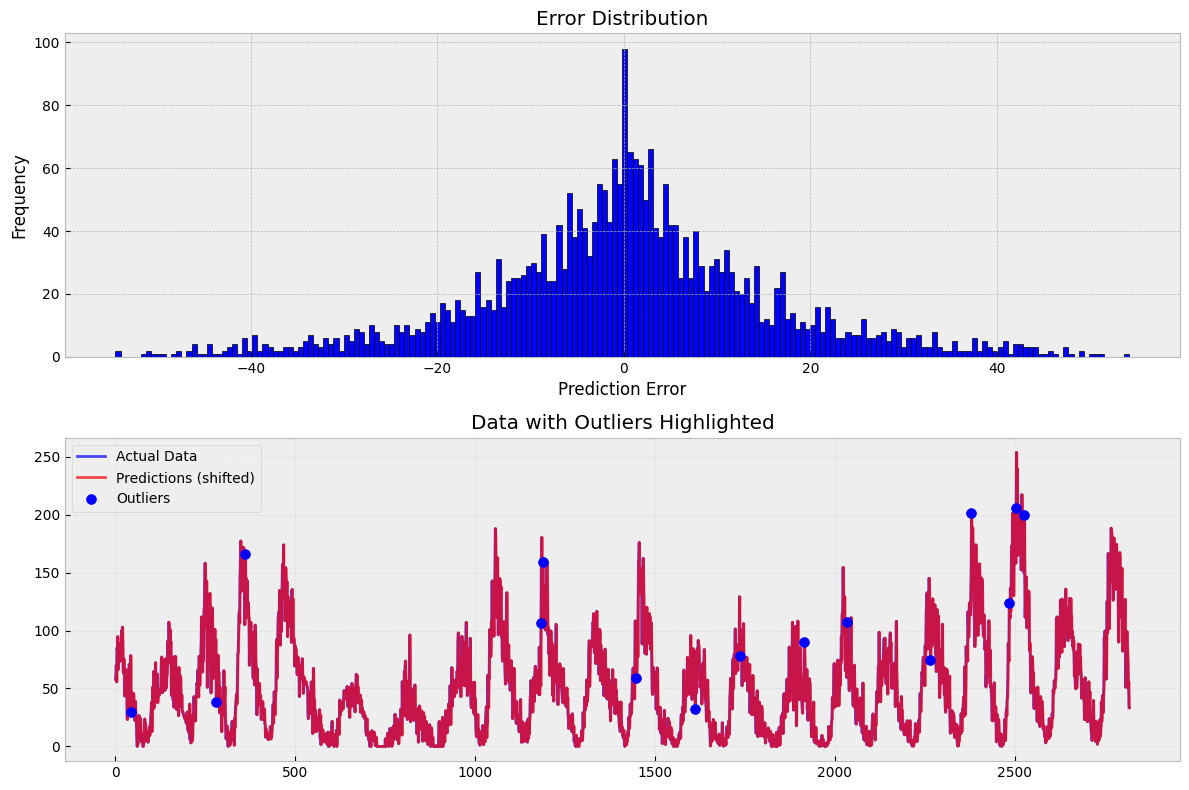

In [13]:
outliers_indices = outlier_detector(df_cleaned, column='Sunspots')

The function still recognize some outliers, but they are less than before.

### Task 1.2.7: Analyze time series properties (stationarity, autocorrelation)

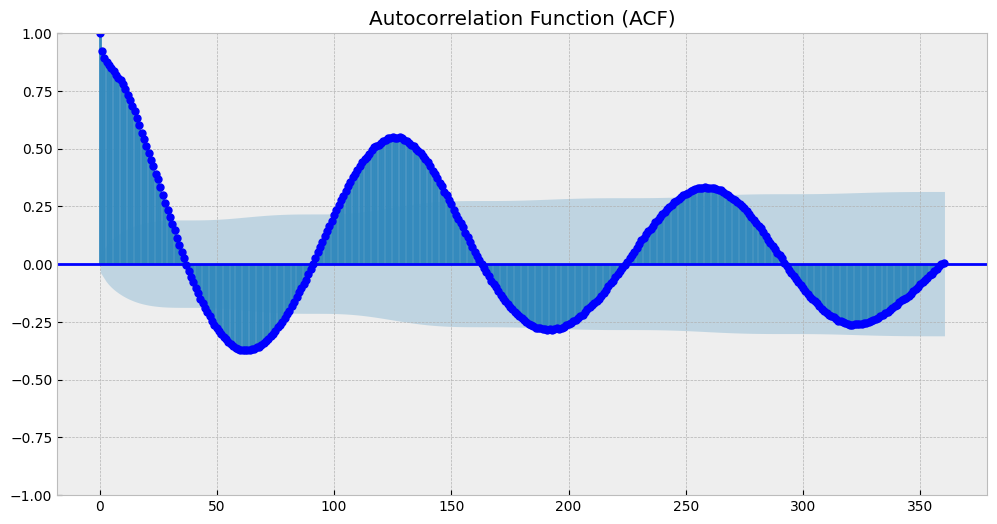

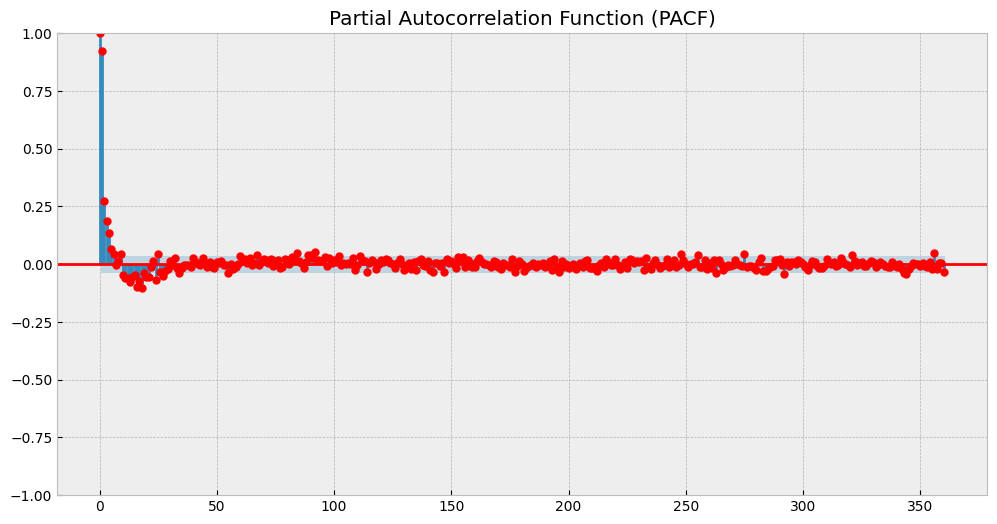

ADF test for Sunspots:
  Test statistic: -9.567667511913076
  p-value: 2.333452143866306e-16
  # lags used: 27
  # observations: 2792
    critical 1%: -3.432694313168895
    critical 5%: -2.862575752726396
    critical 10%: -2.5673213632123297
Conclusion: Reject the null hypothesis (series is stationary)



In [14]:
plot_autocorrelation(df, column='Sunspots', lags=360)

The dataset clearly shows strong autocorrelation at various lags, indicating that past sunspot numbers have a significant influence on future values. The autocorrelation function (ACF) plot reveals that the correlation decreases gradually as the lag increases, suggesting that sunspot activity has a persistent effect over time. Moreover, the partial autocorrelation function (PACF) plot indicates that there are significant correlations at specific lags especially at lag 1 and lag 12, which may correspond to seasonal patterns in sunspot activity.
**Moreover, the rejection of the null hypothesis confirms the series to be stationary.**

Train size: (2256, 2), Test size: (564, 2)


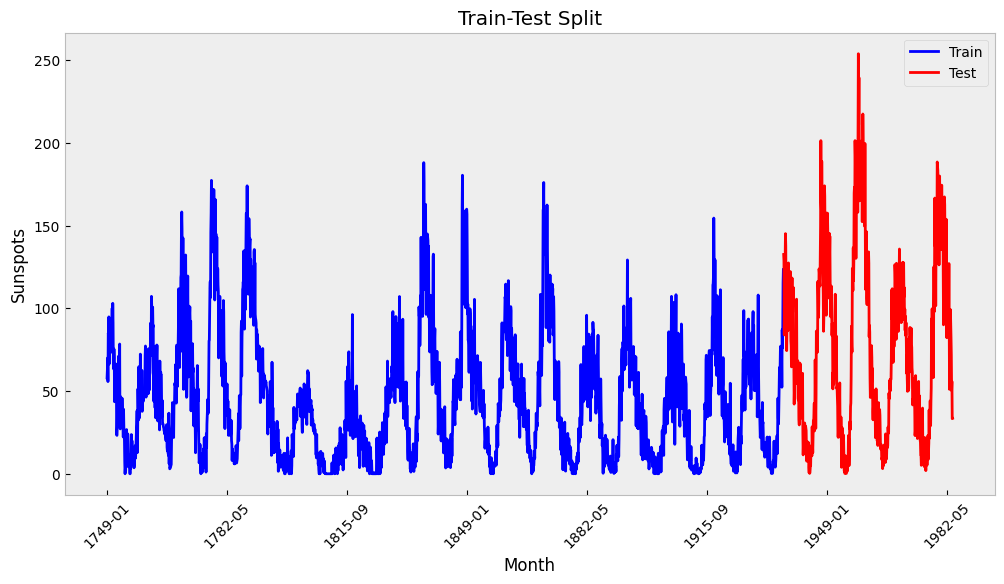

In [15]:
train_df, test_df = split_train_test(df_cleaned, test_size=0.2)

The function split the dataset as expected.

### Task 1.2.8: Split data into training and testing sets and scaling

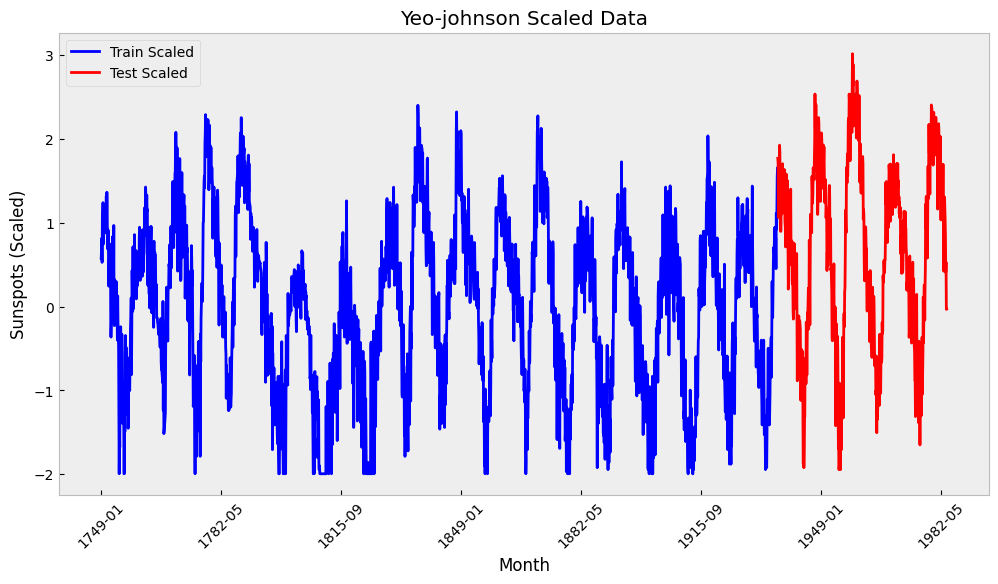

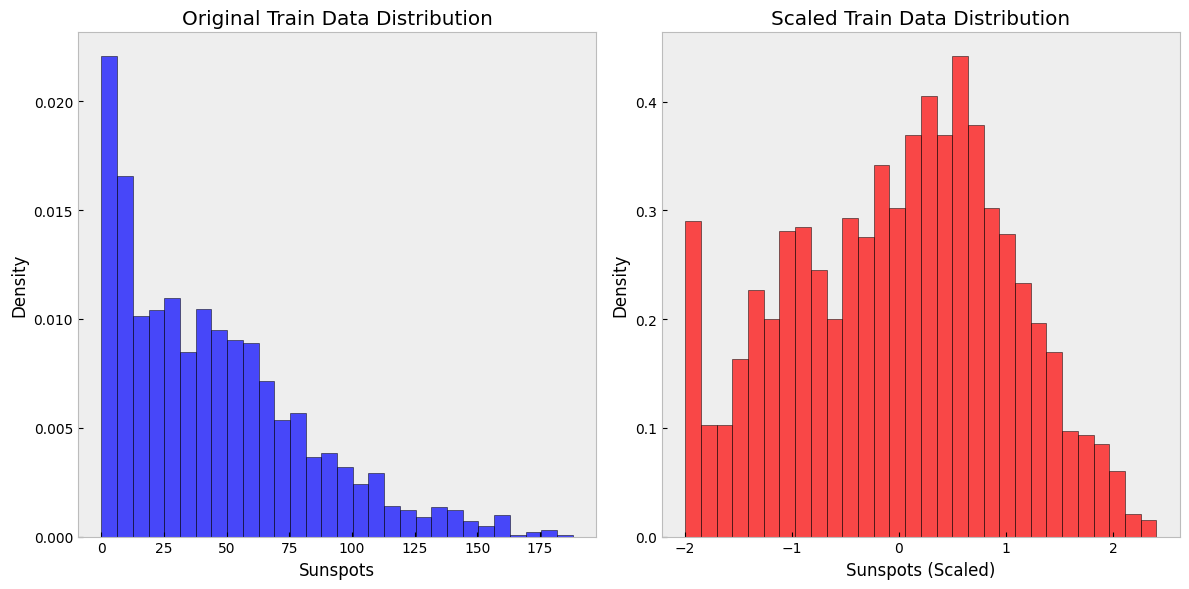

Initial skewness: 0.9811684401312263
Scaled skewness: -0.13277105745492968


In [16]:
train_scaled, test_scaled, scaler = apply_scaling_and_show(train_df, test_df, method='yeo-johnson', column='Sunspots')

The yeo-johnson transformation was applied to reduce skewness in the sunspot number distribution. The initial skewness of 0.98 was rduced to -0.13 which makes neural network training more effective. The transformation helps to stabilize variance and make the data more normally distributed, which is beneficial for many machine learning algorithms.

# Task 2: Model Architecture Design

## Task 2.1: Define hyperparameters and model configurations

The model will be tested on 6 forecast horizons: 1, 3, 5 months ahead and with 1, 120, 240 months of training data. Some hyperparameters will be tested respecteively for the RNN and the TCN model.

In [17]:
# forecast_horizon_list = [1,3,5] # forecast horizons in months
forecast_horizon_list = [1,2,3,4,5,6] # forecast horizons in months

# forecast_horizon_list = [4,6] # forecast horizons in months

time_steps_list = [12, 12*10, 12*20] # time steps: 1 year, 5 years, 10 years
# time_steps_list = [12*20] # time steps: 1 year, 5 years, 10 years

Explanation of the parameters tested for RNN/TCN:
1. **units**: Number of neurons in each layer. More units can capture more complex patterns but may lead to overfitting.
2. **dropout_rate**: Fraction of the input units to drop for regularization. Higher dropout rates can prevent overfitting but may also hinder learning.
3. **filters**: Number of filters in the TCN layers. More filters can capture more features but increase computational cost.
4. **kernel_size**: Size of the convolutional kernel. Larger kernels can capture longer-term dependencies but may also increase the number of parameters.
5. **epochs**: Number of training iterations. More epochs 
can lead to better convergence but may also cause overfitting if too high.
6. **batch_size**: Number of samples per gradient update. Smaller batch sizes can lead to noisier updates but may help in generalization.

In [ ]:
rnn_param_list = [
    # higher complexity more units / filters moderate dropout - significant for capacity
    {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16},
    
    # eexperiment with kernel/pool size (wider kernel for more context, smaller pool) - significant for feature extraction
    {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16},
]


dense_param_list = [
    #higher complexity (larger layers, moderate dropout) - significant for capacity
    {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16},
    
    # Experiment with higher dropout (for robustness to overfitting) - significant for regularization
    {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16},
]



total_configurations_for_rnn = len(forecast_horizon_list) * len(time_steps_list) * len(rnn_param_list)
total_configurations_for_dense = len(forecast_horizon_list) * len(time_steps_list) * len(dense_param_list)
print(f"Total configurations to evaluate (RNN): {total_configurations_for_rnn}")
print(f"Total configurations to evaluate (Dense): {total_configurations_for_dense}")

Total configurations to evaluate (RNN): 36
Total configurations to evaluate (Dense): 36


Due to the number of combinations, gpu will be used to speed up the training process so the training function was adapted accordingly.

## Task 2.2: Create time series sequences for model training

A function to split was created to split the time series data into sequences of a specified length (input_length) and corresponding target values (forecast_horizon). This function generates input-output pairs suitable for training time series forecasting models.

In [19]:
X_train_scaled, y_train, X_test_scaled, y_test = create_time_series_split(train_scaled, test_scaled, time_steps=12, verbose=True, forecast_horizon=4)

Number of training samples: 2241
Number of test samples: 549
X_train shape: (2241, 12, 1)
y_train shape: (2241, 4, 1)
X_test shape: (549, 12, 1)
y_test shape: (549, 4, 1)


# Task 3: Model Training and Evaluation



## Task 3.1: Build RNN model architecture

The build rnn function constructs a Recurrent Neural Network (RNN) model using LSTM layers for time series forecasting. The model consists of two LSTM layers with dropout regularization to prevent overfitting, followed by a dense output layer. The model is compiled with the Adam optimizer and mean squared error loss function, making it suitable for regression tasks.

In [20]:
def build_rnn_model(input_shape, units=50, dropout=0.2, filters=32, kernel_size=3, pool_size=2, output_units=1):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'), # this layer extracts features from the time series
        MaxPooling1D(pool_size=pool_size), # this layer reduces the dimensionality of the feature maps
        Dropout(dropout), # this layer helps prevent overfitting
        SimpleRNN(units, activation='tanh'), # RNN layer to capture temporal dependencies
        LayerNormalization(), # normalize the outputs of the RNN layer
        Dropout(dropout), # another dropout layer
        Dense(output_units), # output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
    return model

## Task 3.2: Train RNN model for single-step prediction

A function to test the RNN model was created to train and evaluate the RNN model for multiple and single-step prediction. The function takes in training and testing data, along with hyperparameters such as units, dropout rate, filters, kernel size, and pool size. It builds the RNN model using the specified architecture, trains it on the training data, and evaluates its performance on the testing data. The function returns the best trained model and its evaluation metrics.

Testing RNN with multiple parameters in recursive mode:


I0000 00:00:1763302329.465068 2790065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13207 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763302333.143255 2790212 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.8231, Test RMSE: 20.5650
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 18.4454, Test RMSE: 30.2959
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.6559, Test RMSE: 21.8976
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 16.2182, Test RMSE: 29.1531
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_s

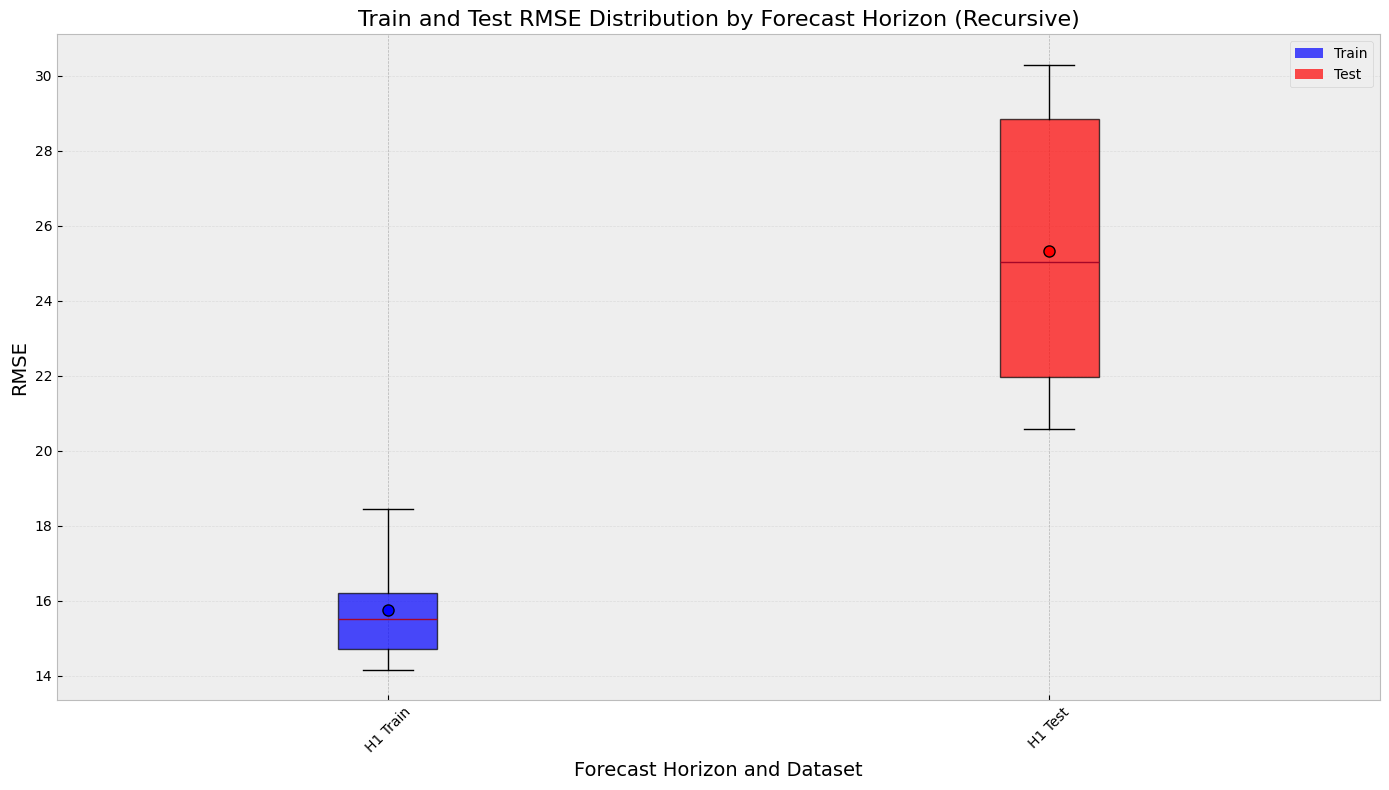


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 25.4304, Std Test RMSE 4.8654
  Time Steps 120: Mean Test RMSE 25.5253, Std Test RMSE 3.6277
  Time Steps 240: Mean Test RMSE 25.0430, Std Test RMSE 2.8340


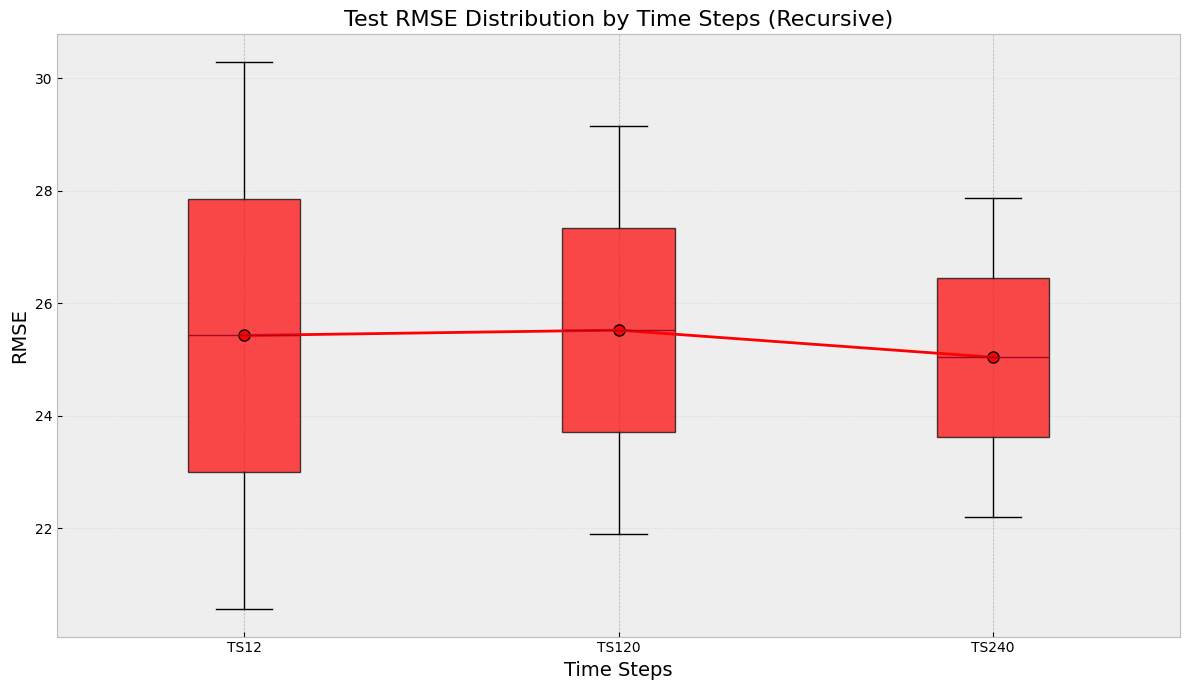


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.8231, Test RMSE 20.5650
--------------------------------------------------


In [21]:
print("Testing RNN with multiple parameters in recursive mode:")
results_best_rnn_model_one_step = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_rnn_model, 
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=[1],
    recursive=True,
    base_name='rnn_single_step')


The various combinations tested led to good generalization performance on the test set.
The best model achieved an rmse of 14.8 on the train set and 20.56 on the test set for the 1 month ahead forecast horizon using 240 months of training data.
Looks like the rnn model in recursive mode performs similarly with 12 and 240 months of training data, but 240 months offers less variance of rmse.

## Task 3.3: Build Dense model architecture

In [22]:
def build_dense_model(input_shape, units=50, dropout=0.2, output_units=1):
    model = Sequential([
        Input(shape=input_shape),  # input layer
        Flatten(),  # flatten the input becaause Dense layers expect 1D input
        Dense(units, activation='relu'),  # first hidden dense layer
        LayerNormalization(),  # normalize outputs (matches RNN's LayerNormalization)
        Dropout(dropout),  # dropout layer for regularization
        Dense(units, activation='relu'),  # second hidden dense layer (added for complexity)
        Dropout(dropout),  # another dropout layer for regularization (added for complexity)
        Dense(output_units)  # output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
    return model

## Task 3.4: Train Dense model for single-step prediction


Testing Dense in recursive mode:
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 15.5749, Test RMSE: 28.6560
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.0083, Test RMSE: 23.0196
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 17.8025, Test RMSE: 41.7969
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 20.9289, Test RMSE: 45.6720
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 16.0004, Test RMSE: 40.9445
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 10

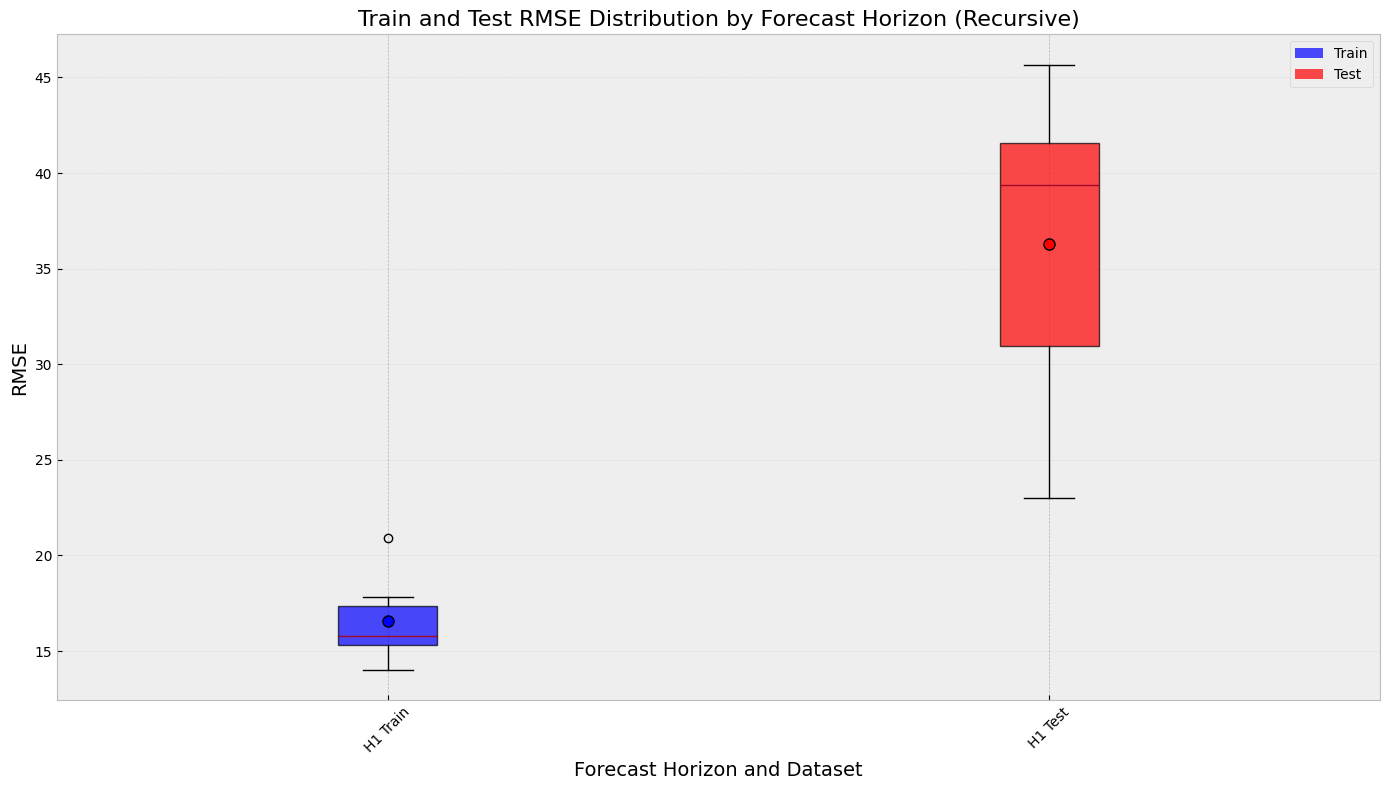


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 25.8378, Std Test RMSE 2.8182
  Time Steps 120: Mean Test RMSE 43.7345, Std Test RMSE 1.9376
  Time Steps 240: Mean Test RMSE 39.3676, Std Test RMSE 1.5768


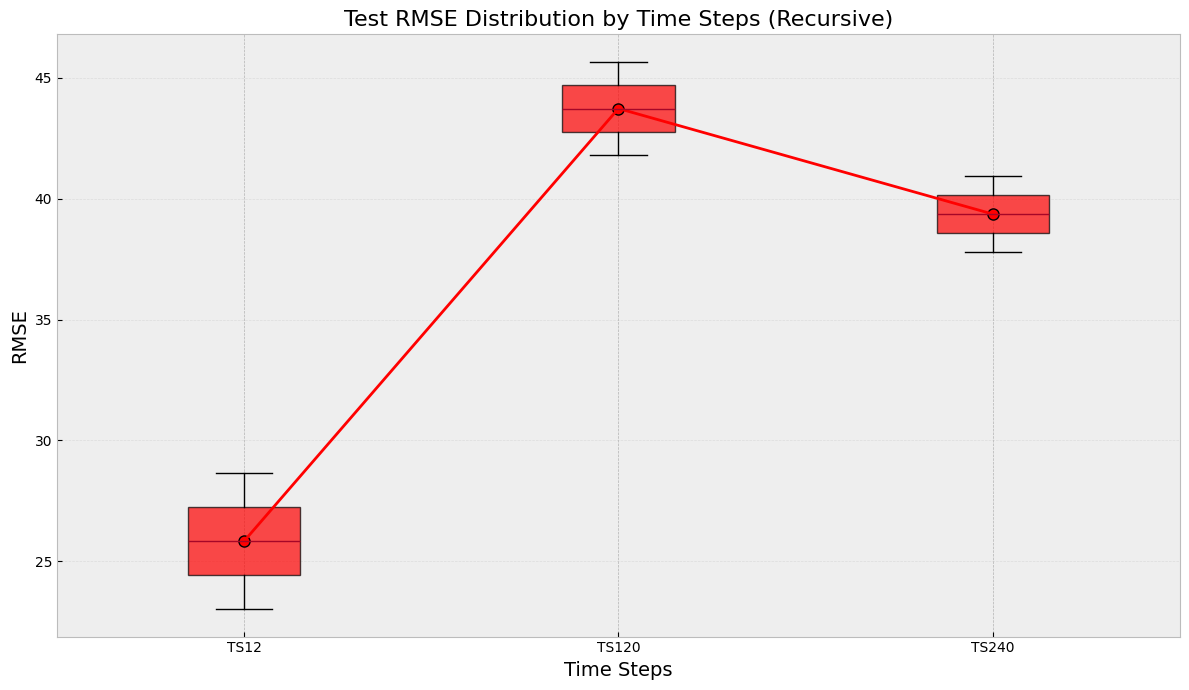


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.0083, Test RMSE 23.0196
--------------------------------------------------


In [23]:
print("\nTesting Dense in recursive mode:")
results_best_dense_model_one_step = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_dense_model, 
    param_list=dense_param_list,
    scaler=scaler,
    forecast_horizon_list=[1],
    recursive=True,
    base_name='dense_single_step'
)


The dense model was also tested for single-step prediction but the performance was worse than the RNN model, moreover it tends to overfit more easily because of the lack of temporal dependencies handling present in RNNs(1d convolutions or LSTM layers).
The dense model, in contrary to the RNN model, performs better with less data(12 months) because of its simplicity, in fact it doesn't need long sequences to learn temporal dependencies.

## Task 3.5: Visualize single-step predictions

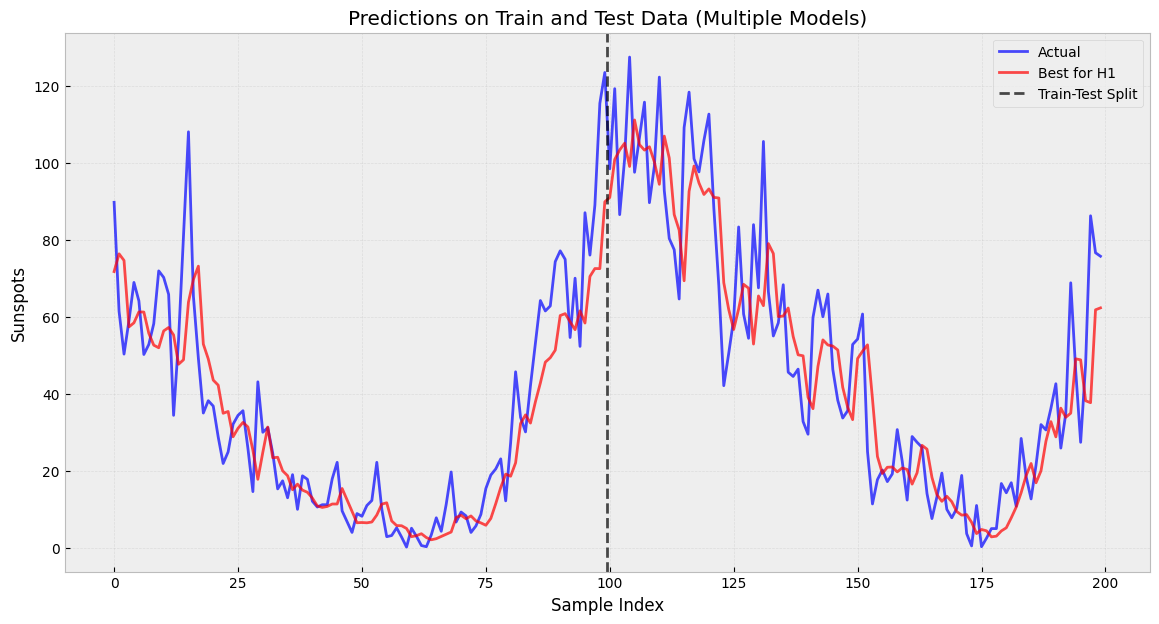

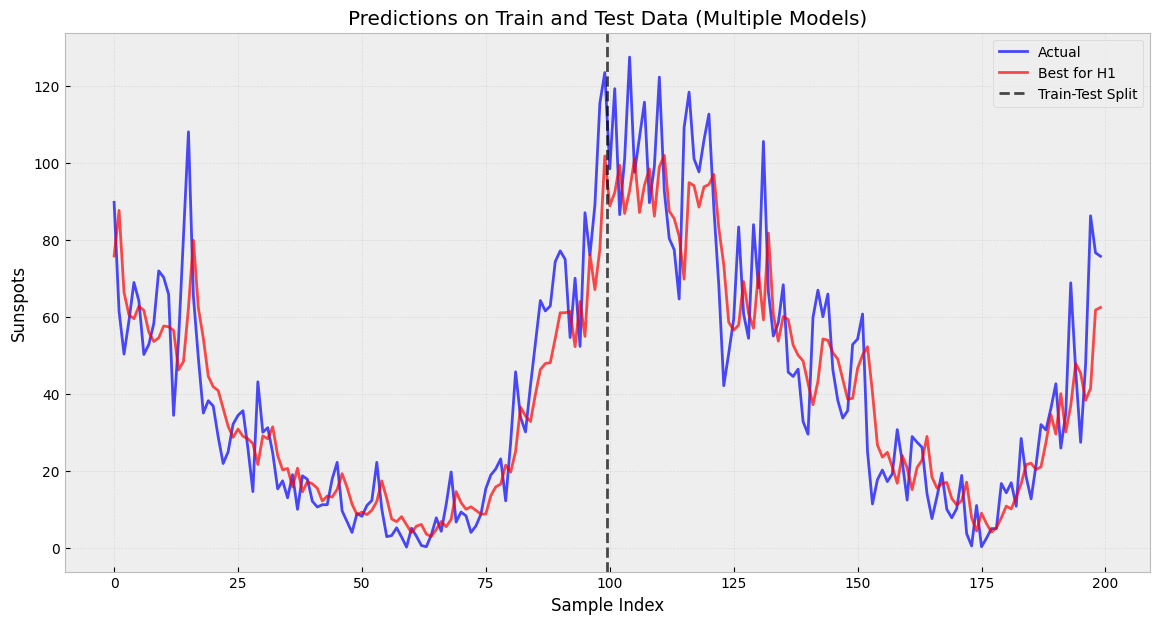

In [24]:
# Visualize the best RNN model with its own time_steps
rnn_model_path = results_best_rnn_model_one_step['best_model_paths'][0]
best_config_rnn = results_best_rnn_model_one_step['best_configurations'][0]
time_steps_rnn = best_config_rnn['time_steps']
X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn = create_time_series_split(train_scaled, test_scaled, time_steps=time_steps_rnn, verbose=False, forecast_horizon=1)
visualize_predictions([rnn_model_path], X_test_rnn, y_test_rnn, scaler=scaler, X_train=X_train_rnn, y_train=y_train_rnn, n_train=100, n_test=100, labels=[results_best_rnn_model_one_step['best_model_names'][0]])

# Visualize the best Dense model with its own time_steps
dense_model_path = results_best_dense_model_one_step['best_model_paths'][0]
best_config_dense = results_best_dense_model_one_step['best_configurations'][0]
time_steps_dense = best_config_dense['time_steps']
X_train_dense, y_train_dense, X_test_dense, y_test_dense = create_time_series_split(train_scaled, test_scaled, time_steps=time_steps_dense, verbose=False, forecast_horizon=1)
visualize_predictions([dense_model_path], X_test_dense, y_test_dense, scaler=scaler, X_train=X_train_dense, y_train=y_train_dense, n_train=100, n_test=100, labels=[results_best_dense_model_one_step['best_model_names'][0]])
gc.collect()
tf.keras.backend.clear_session()

The dashed line indicates when the test dataset starts. The rnn model seems to be less susceptible to volatility. On the other hand the dense model shows more volatility and overfitting.

# Task 4: Multi-Step Forecasting

## Task 4.1: Train RNN model for multi-step prediction - Recursive approach

Testing RNN Recursive:
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.8218, Test RMSE: 20.9751
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 18.6643, Test RMSE: 30.9204
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.3708, Test RMSE: 21.1837
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 17.1343, Test RMSE: 29.1041
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, '

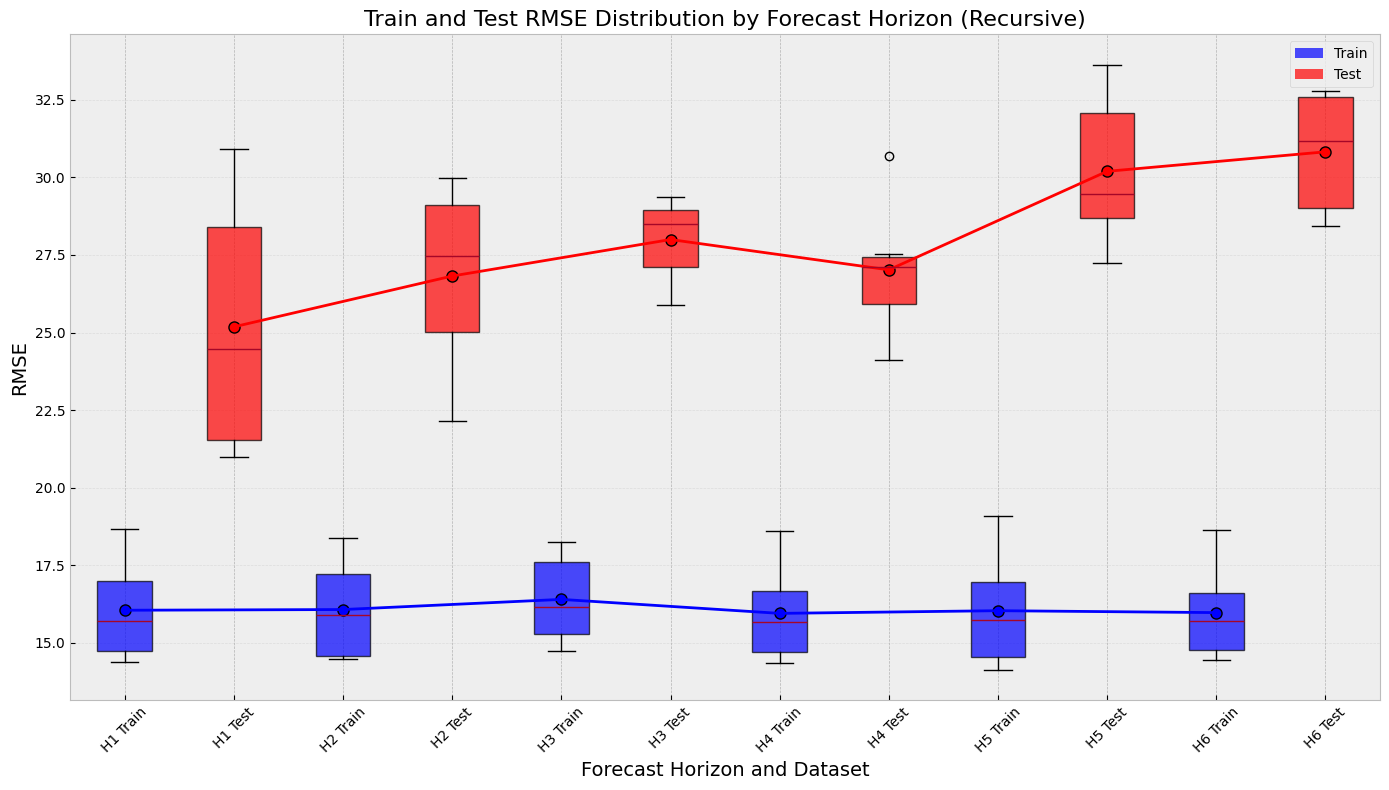


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 28.6638, Std Test RMSE 3.8285
  Time Steps 120: Mean Test RMSE 27.7719, Std Test RMSE 2.2525
  Time Steps 240: Mean Test RMSE 27.5838, Std Test RMSE 3.1166


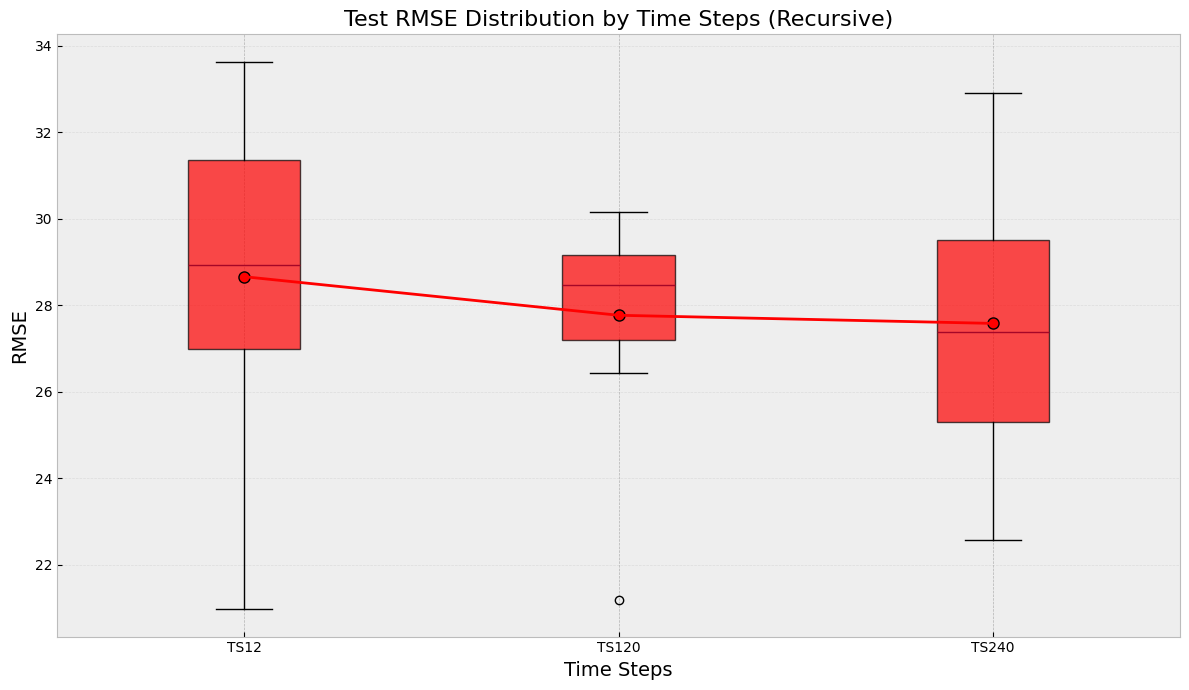


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.8218, Test RMSE 20.9751
Horizon 2: Best for H2 with Train RMSE 14.4860, Test RMSE 22.1564
Horizon 3: Best for H3 with Train RMSE 14.7494, Test RMSE 25.8855
Horizon 4: Best for H4 with Train RMSE 16.7225, Test RMSE 24.1224
Horizon 5: Best for H5 with Train RMSE 14.1223, Test RMSE 27.2283
Horizon 6: Best for H6 with Train RMSE 16.7977, Test RMSE 28.4466
--------------------------------------------------


In [25]:
print("Testing RNN Recursive:")
results_rnn_recursive = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_rnn_model, 
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=True,
    base_name="rnn"
)

---

#### What does the graph Distribution "Train and Test RMSE Distribution by Forecast (mode)" tell us
The graph shows the distribution of RMSE values for both training and testing datasets across different forecast horizons using different parameter configurations. It helps us understand how well the model is performing in terms of accuracy and generalization by testing multiple configurations.

#### What does the graph "Test RMSE distribution by Time Steps (mode)" tell us
The graph illustrates the distribution of RMSE values for the test dataset across different time steps using various parameter configurations. It provides insights into how the model's performance varies using different amount of data and forecast horizons.

---

The rnn on multiple time steps ahead prediction was tested using the recursive approach, where the model's previous predictions are used as inputs for future predictions. This method allows the model to generate forecasts for multiple time steps ahead by iteratively feeding back its own outputs as inputs for subsequent predictions.
This approach seems stable across all forecast horizons.
The low variance of the **fourth time horizon** suggests that the model is stable and consistent in its predictions over multiple time steps ahead and varying the parameters doesn't affect much the performance.


## Task 4.3: Train RNN model for multi-step prediction - Direct approach

Testing RNN direct:
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.7160, Test RMSE: 21.9573
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 19.2576, Test RMSE: 32.2718
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.9996, Test RMSE: 24.0834
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 17.5254, Test RMSE: 31.1881
Forecast Horizon: 1, Time Steps: 240, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3,

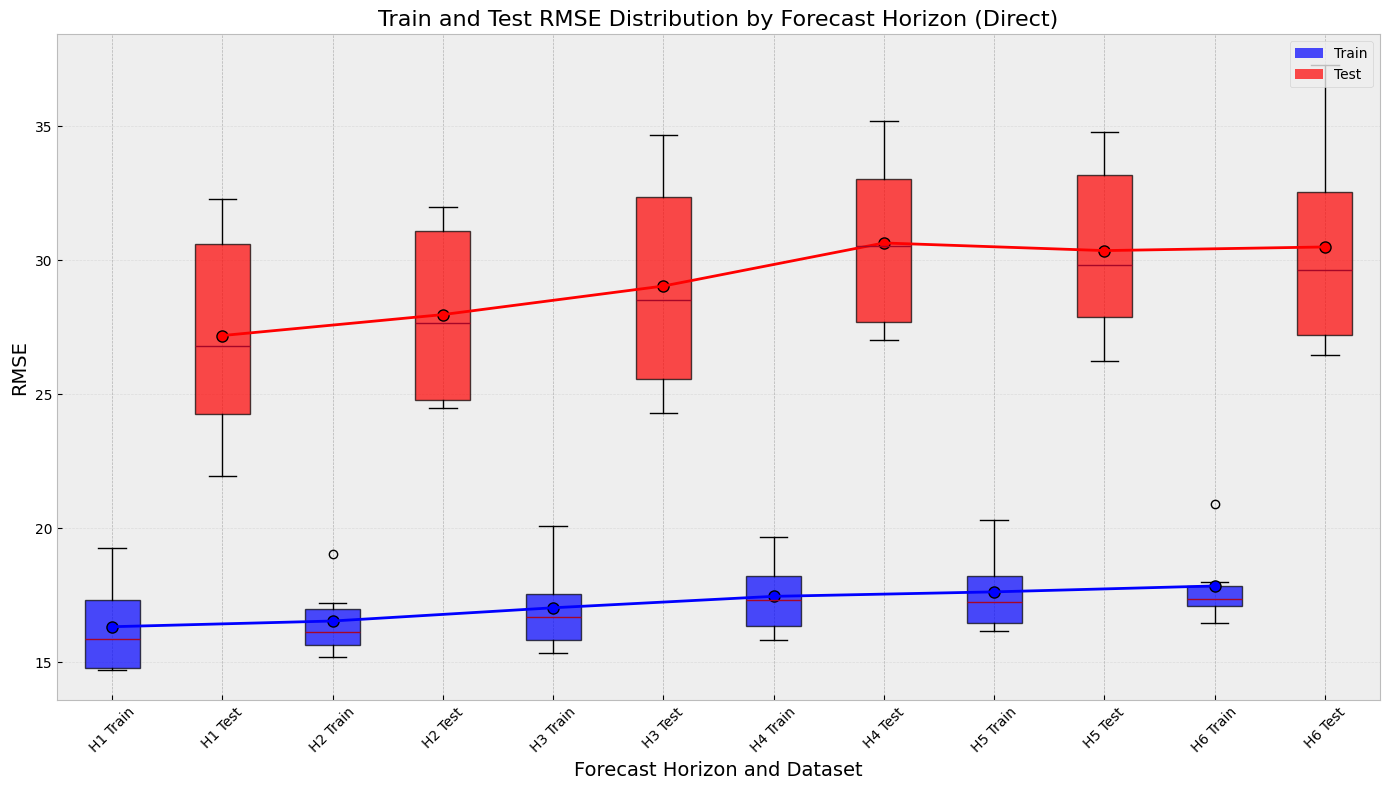


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 29.9560, Std Test RMSE 4.4802
  Time Steps 120: Mean Test RMSE 29.0209, Std Test RMSE 3.2249
  Time Steps 240: Mean Test RMSE 28.8643, Std Test RMSE 3.3944


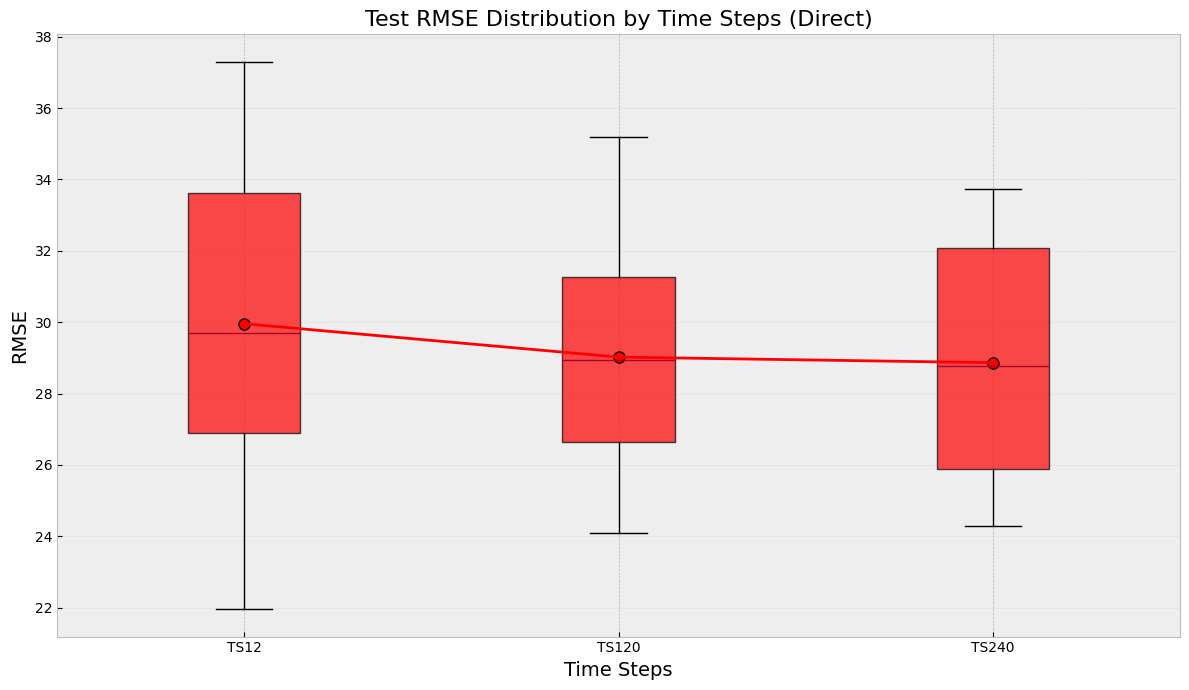


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.7160, Test RMSE 21.9573
Horizon 2: Best for H2 with Train RMSE 15.9742, Test RMSE 24.4937
Horizon 3: Best for H3 with Train RMSE 15.5192, Test RMSE 24.2843
Horizon 4: Best for H4 with Train RMSE 17.0770, Test RMSE 27.0024
Horizon 5: Best for H5 with Train RMSE 16.9122, Test RMSE 26.2556
Horizon 6: Best for H6 with Train RMSE 17.0012, Test RMSE 26.4747
--------------------------------------------------


In [26]:

print("Testing RNN direct:")
results_rnn_direct = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_rnn_model, 
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=False,
    base_name="rnn"
)


RNN model with the direct approach for multi-step forecasting was also tested, where separate models are trained for each forecast horizon. Each model is specifically designed to predict a certain number of time steps ahead, allowing for more specialized learning for each horizon. It slightly underperforms the recursive approach but it is more stable and again it performs better with longer training data (240 months).

## Task 4.4: Train Dense model for multi-step prediction - Recursive approach

Testing Dense Recursive:
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 15.7991, Test RMSE: 30.9830
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 15.8775, Test RMSE: 30.1135
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 13.7434, Test RMSE: 31.8156
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 16.2429, Test RMSE: 37.1425
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 15.8653, Test RMSE: 41.3722
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch

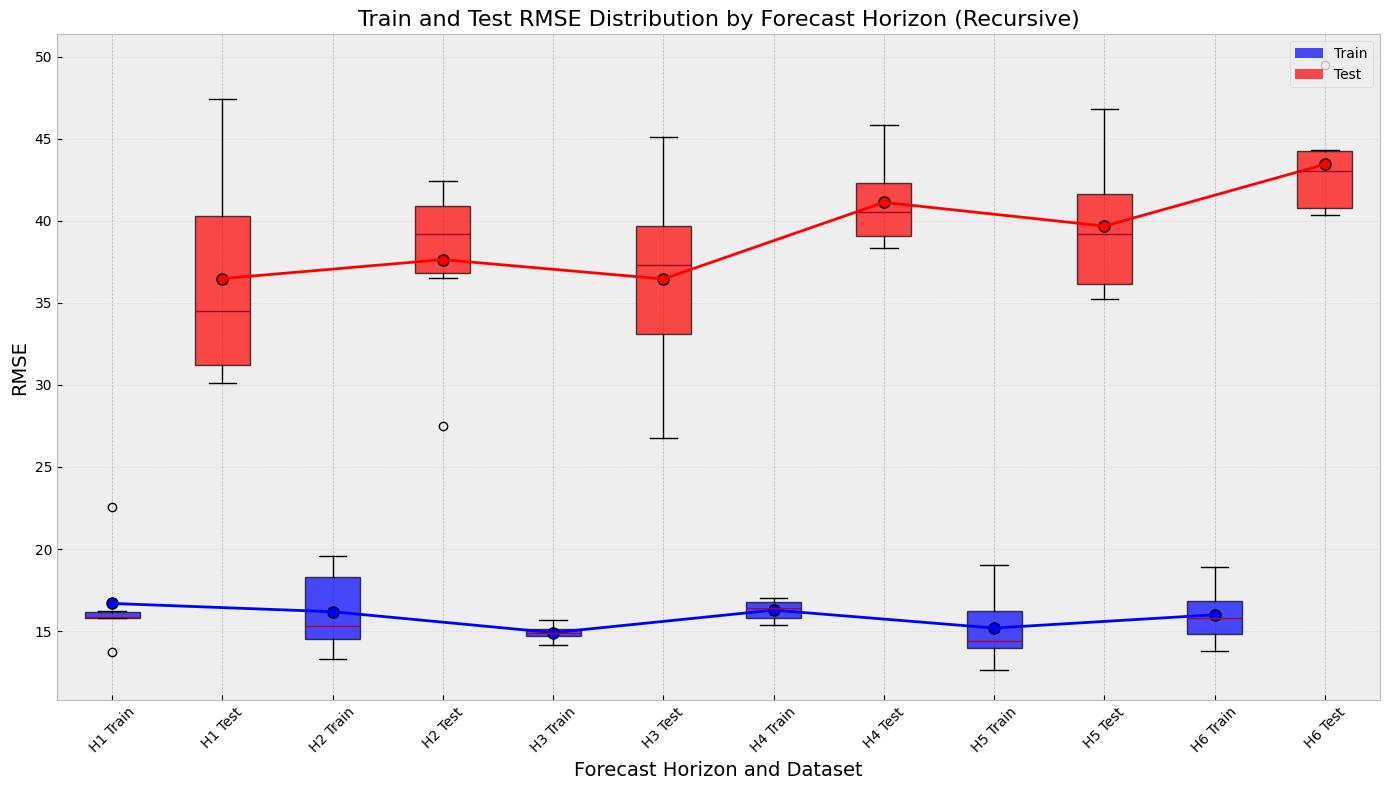


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 36.9247, Std Test RMSE 7.3140
  Time Steps 120: Mean Test RMSE 39.0430, Std Test RMSE 2.9000
  Time Steps 240: Mean Test RMSE 41.4382, Std Test RMSE 3.5887


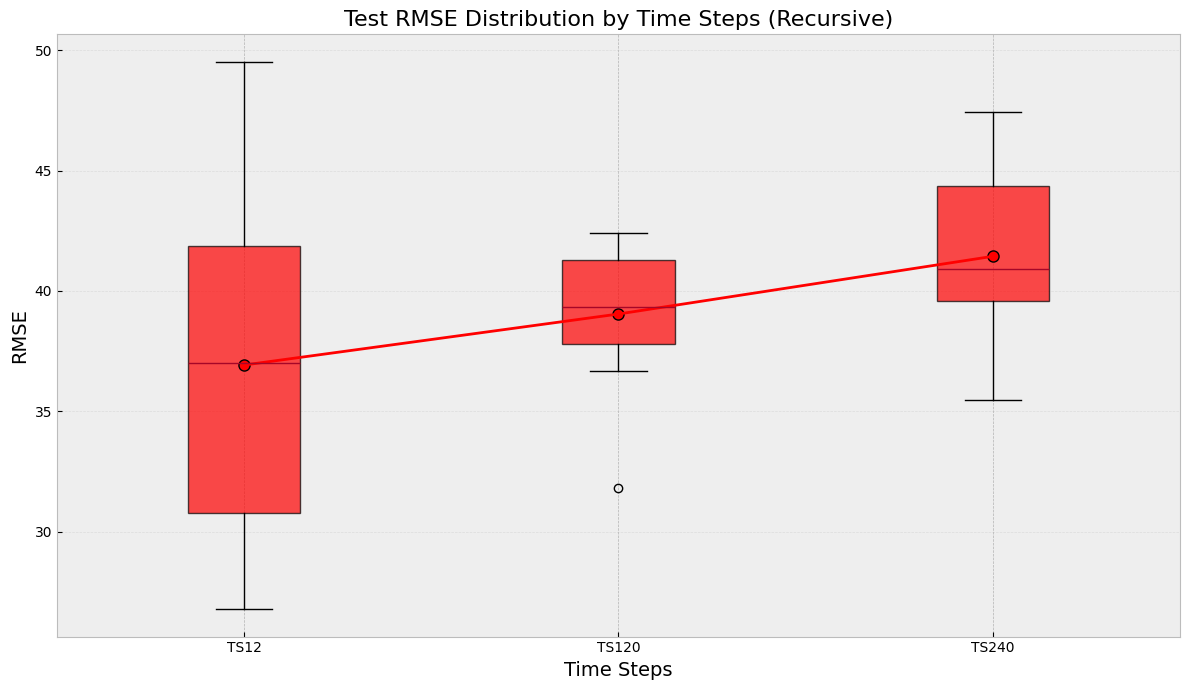


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 15.8775, Test RMSE 30.1135
Horizon 2: Best for H2 with Train RMSE 14.5053, Test RMSE 27.5119
Horizon 3: Best for H3 with Train RMSE 14.1241, Test RMSE 26.7861
Horizon 4: Best for H4 with Train RMSE 15.3532, Test RMSE 38.3437
Horizon 5: Best for H5 with Train RMSE 14.6084, Test RMSE 35.2639
Horizon 6: Best for H6 with Train RMSE 14.8260, Test RMSE 40.3464
--------------------------------------------------


In [27]:
print("Testing Dense Recursive:")
results_dense_recursive = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_dense_model, 
    param_list=dense_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=True,
    base_name="dense"
)

The dense model was also tested for multiple time steps ahead prediction using the direct approach.
It underperforms the RNN models and it is not able to capture the temporal dependencies needed for multi-step forecasting. The recursion deviates from the actual values as the forecast horizon increases.
The dense model underperforms surprisingly on the first time horizon showing more variance of the rmse on the test set.
**The difference between training and test rmse is quite high suggesting overfitting.**

## Task 4.5: Train Dense model for multi-step prediction - Direct approach

Testing Dense Direct:
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.3839, Test RMSE: 25.0235
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 18.1335, Test RMSE: 36.9452
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 13.3326, Test RMSE: 32.0469
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16}
Train RMSE: 24.1074, Test RMSE: 51.7216
Forecast Horizon: 1, Time Steps: 240, Recursive: False
Model Params: {'units': 100, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 13.4852, Test RMSE: 37.1754
Forecast Horizon: 1, Time Steps: 240, Recursive: False
Model Params: {'units': 50, 'dropout': 0.5, 'epochs': 100, 'ba

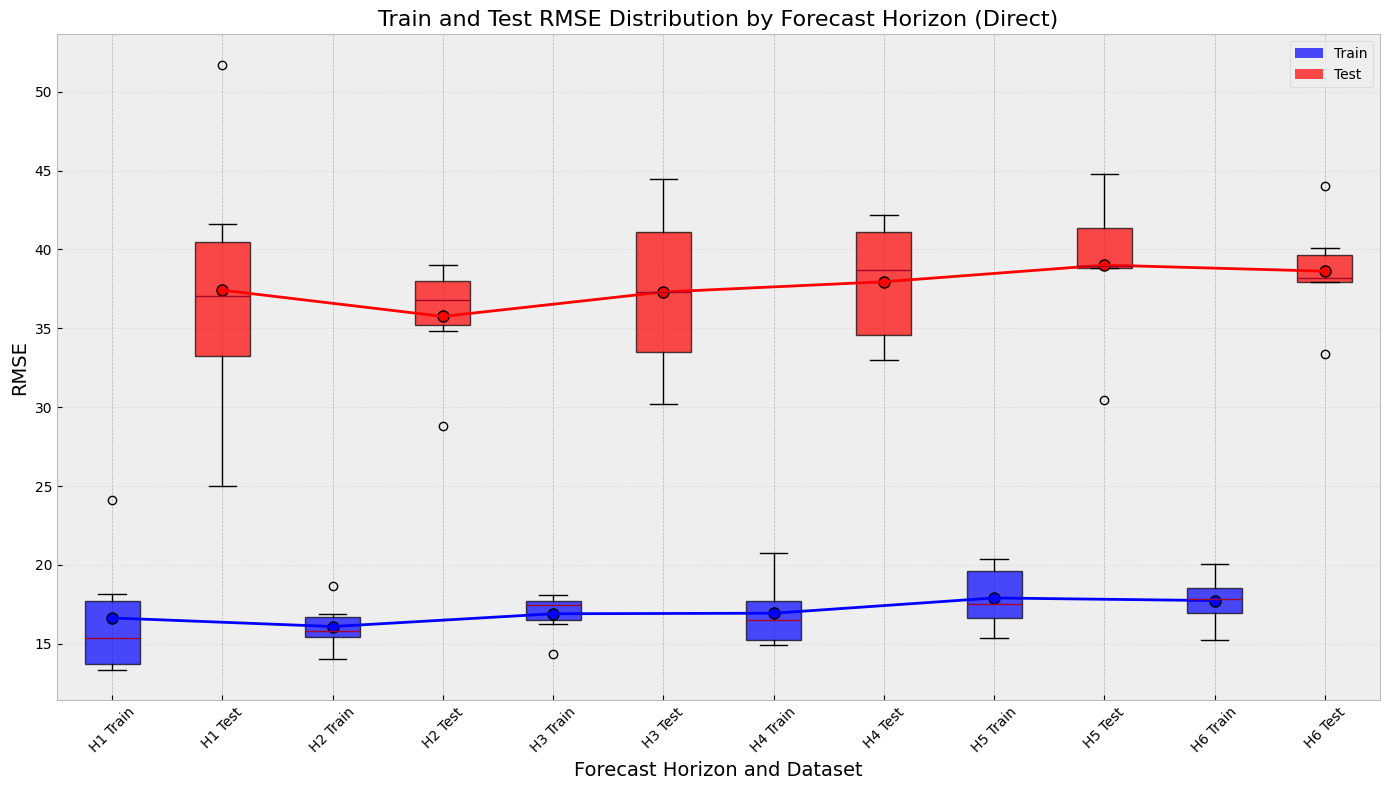


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 33.8807, Std Test RMSE 4.5949
  Time Steps 120: Mean Test RMSE 38.9313, Std Test RMSE 5.1438
  Time Steps 240: Mean Test RMSE 40.2153, Std Test RMSE 2.7299


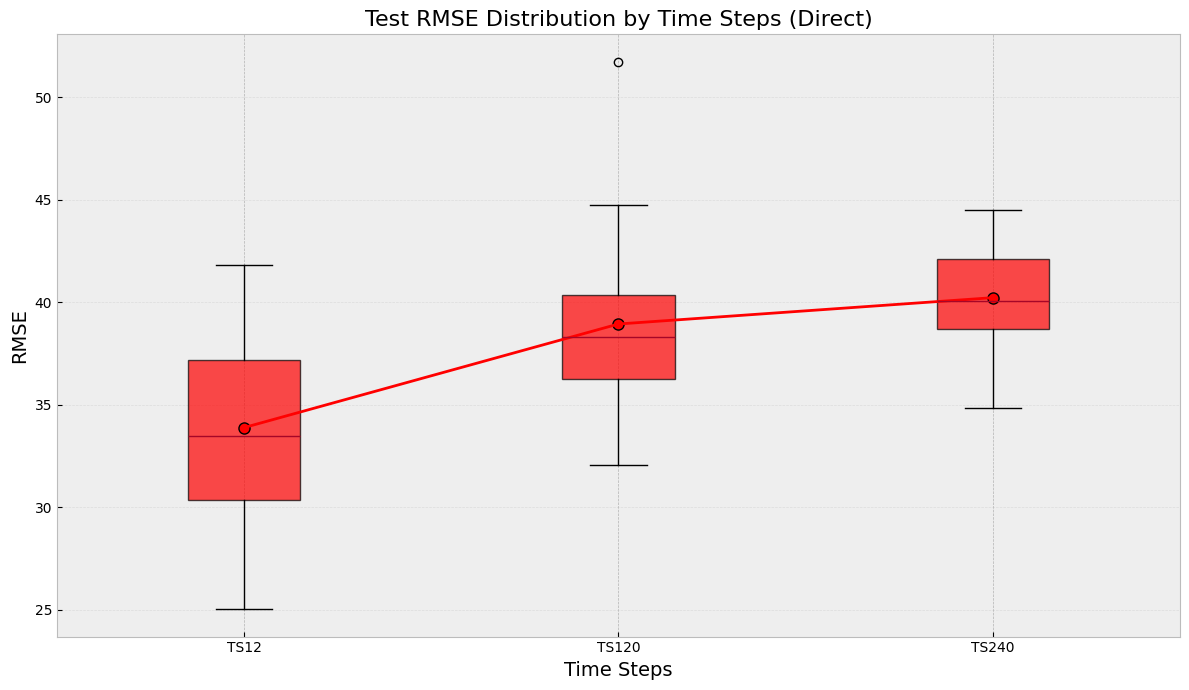


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.3839, Test RMSE 25.0235
Horizon 2: Best for H2 with Train RMSE 16.0714, Test RMSE 28.7940
Horizon 3: Best for H3 with Train RMSE 17.3537, Test RMSE 30.1734
Horizon 4: Best for H4 with Train RMSE 17.9646, Test RMSE 32.9924
Horizon 5: Best for H5 with Train RMSE 17.5966, Test RMSE 30.4386
Horizon 6: Best for H6 with Train RMSE 18.5949, Test RMSE 33.3543
--------------------------------------------------


In [28]:
print("Testing Dense Direct:")
results_dense_direct = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_dense_model,
    param_list=dense_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=False,
    base_name="dense"
)

The dense model with the direct appraoch performs better than the recursive approach but it still **underperforms the RNN models**. are  As we give more data to the dense model the performance sligthly drops.

## Task 4.7: Compare RNN and Dense models performance

Using fixed evaluation window with time_steps=240 for fair comparison


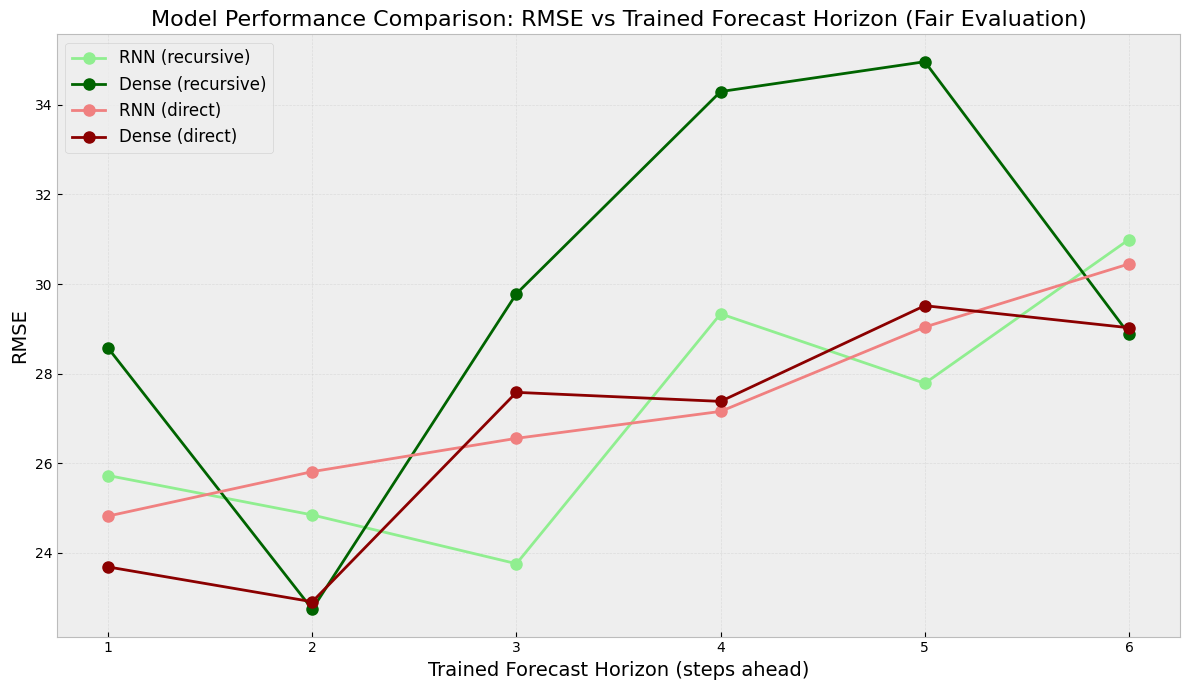


Model Performance Leaderboards (Fair Evaluation - All models tested on same window starting from index 240):
Leaderboard for Forecast Horizon 1:                 Leaderboard for Forecast Horizon 2:               
--------------------------------------------------  --------------------------------------------------
Rank  Model                     RMSE                Rank  Model                     RMSE              
--------------------------------------------------  --------------------------------------------------
1     Dense (direct)            23.6842             1     Dense (recursive)         22.7405           
2     RNN (direct)              24.8197             2     Dense (direct)            22.9066           
3     RNN (recursive)           25.7251             3     RNN (recursive)           24.8454           
4     Dense (recursive)         28.5712             4     RNN (direct)              25.8114           
--------------------------------------------------  --------------

In [46]:
compare_model_performance([
    results_rnn_recursive['best_model_paths'], 
    results_dense_recursive['best_model_paths'],
    results_rnn_direct['best_model_paths'],
    results_dense_direct['best_model_paths']
], 
model_labels=[
    'RNN (recursive)',
    'Dense (recursive)', 
    'RNN (direct)',
    'Dense (direct)'
],
forecast_horizon_list=forecast_horizon_list,
colors=['lightgreen', 'darkgreen', 'lightcoral', 'darkred'],
train_data=train_scaled,
test_data=test_scaled,
scaler=scaler)

For time horizons between 1 and 2 the dense model performs better than the rnn on both recursive and direct approach but for higher time horizons the rnn clearly outperforms the dense model.
The rnn direct is very consistent across different time horizons.
The dense recursive model accumulates error as the forecast horizon increases, leading to significant deviations from actual values for longer-term predictions.

# Task 5: Advanced Architectures

## Task 5.1: Build LSTM model architecture

The lstm should outperform the simple rnn because of its capability to capture long-term dependencies better than simple rnn cells.

In [30]:
def build_lstm_model(input_shape, units=50, dropout=0.2, filters=32, kernel_size=3, pool_size=2, output_units=1):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        Dropout(dropout),
        LSTM(units, activation='tanh'),
        LayerNormalization(),
        Dropout(dropout),
        Dense(output_units)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
    return model

## Task 5.2: Train LSTM model for multi-step prediction - Recursive approach

Testing LSTM recursive:
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.5698, Test RMSE: 19.6056
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 18.7813, Test RMSE: 31.5889
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.0848, Test RMSE: 22.4802
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 16.5370, Test RMSE: 32.7995
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 

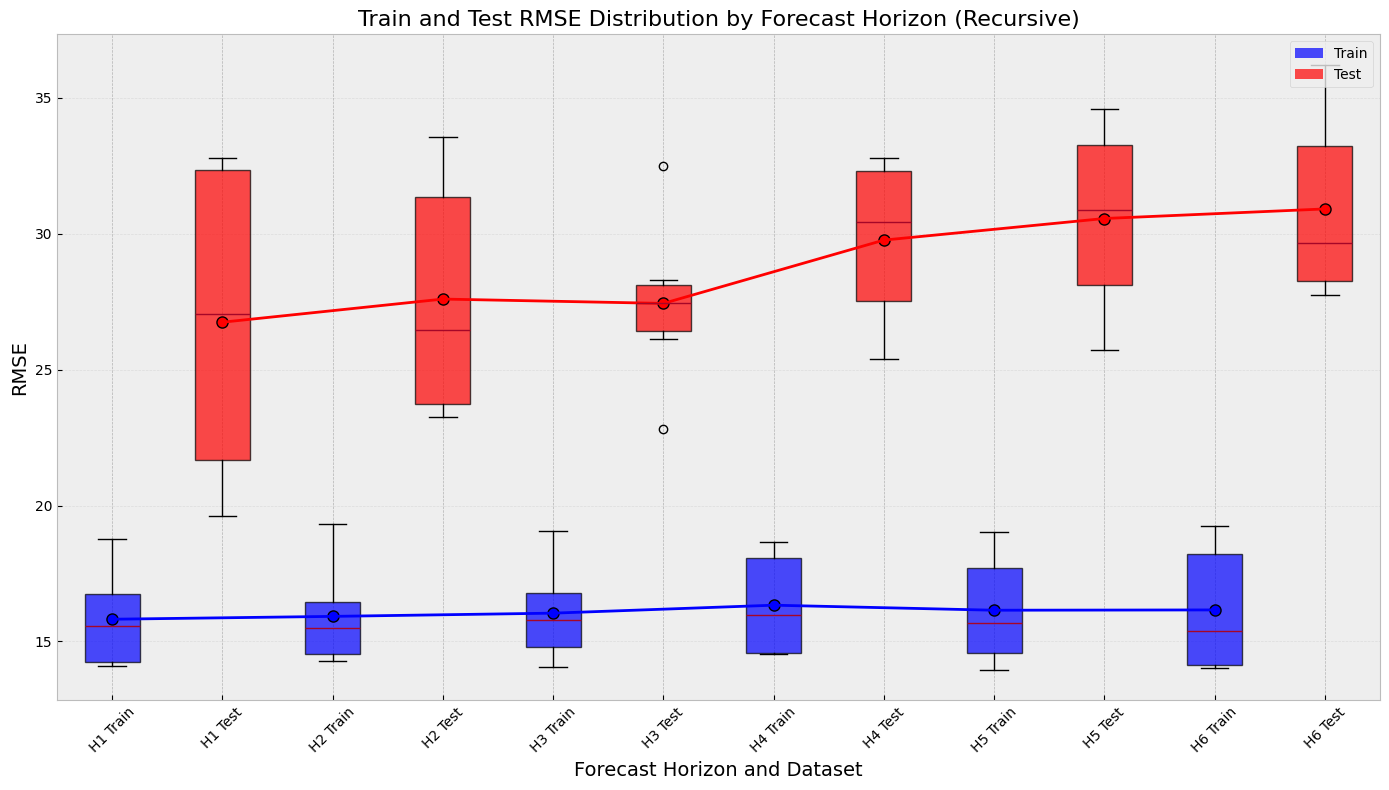


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 28.9306, Std Test RMSE 4.4870
  Time Steps 120: Mean Test RMSE 29.2733, Std Test RMSE 3.4340
  Time Steps 240: Mean Test RMSE 28.3135, Std Test RMSE 4.3432


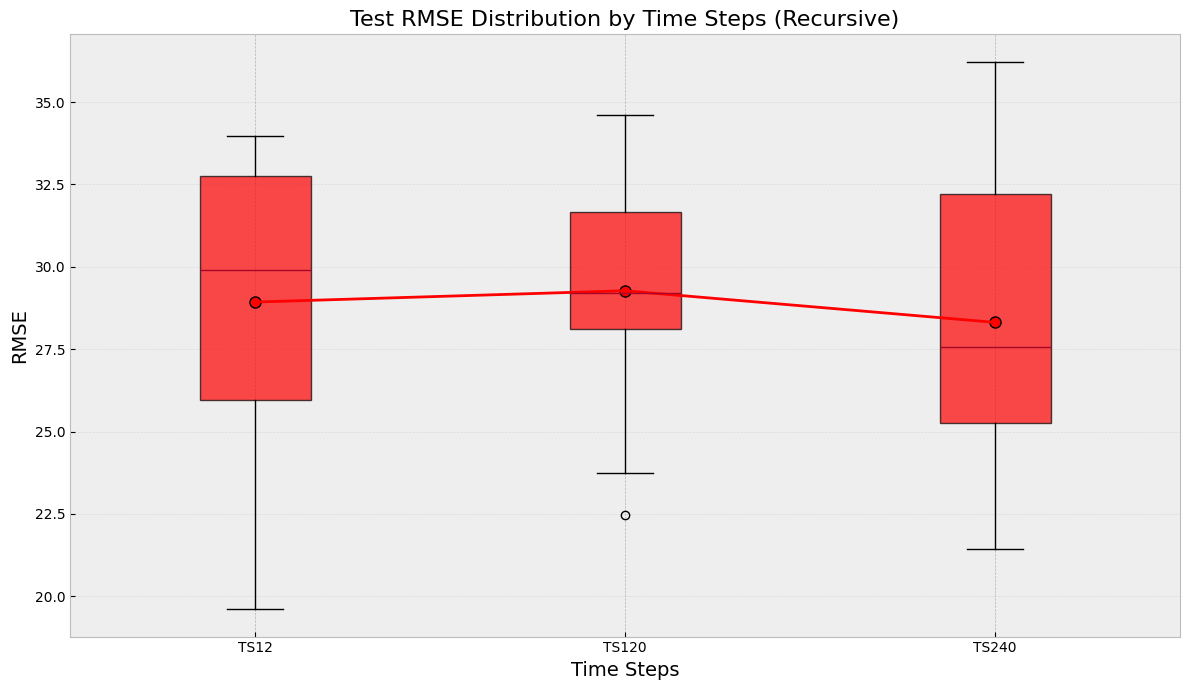


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.5698, Test RMSE 19.6056
Horizon 2: Best for H2 with Train RMSE 14.4916, Test RMSE 23.2596
Horizon 3: Best for H3 with Train RMSE 14.0643, Test RMSE 22.8031
Horizon 4: Best for H4 with Train RMSE 14.5575, Test RMSE 25.4075
Horizon 5: Best for H5 with Train RMSE 13.9491, Test RMSE 25.7433
Horizon 6: Best for H6 with Train RMSE 14.0398, Test RMSE 27.7631
--------------------------------------------------


In [31]:
print("Testing LSTM recursive:")
results_lstm_recursive = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_lstm_model,
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=True,
    base_name="lstm"
)


The lstm generalization is consistent across all the forecast horizons and training data lengths, showing similar performance to the simple rnn model. Moreover giving more training data doesn't improve much the performance. 
Ase we increase the forecast horizon the performance slightly degrades as expected.
There is a low variance at the third time horizon showing stability of the model across different parameter configurations.

## Task 5.3: Train LSTM for multi-step prediction - Direct approach

Testing LSTM Direct:
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.4491, Test RMSE: 20.1522
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 18.6606, Test RMSE: 31.1076
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.7049, Test RMSE: 24.5786
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 16.4330, Test RMSE: 25.0531
Forecast Horizon: 1, Time Steps: 240, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3

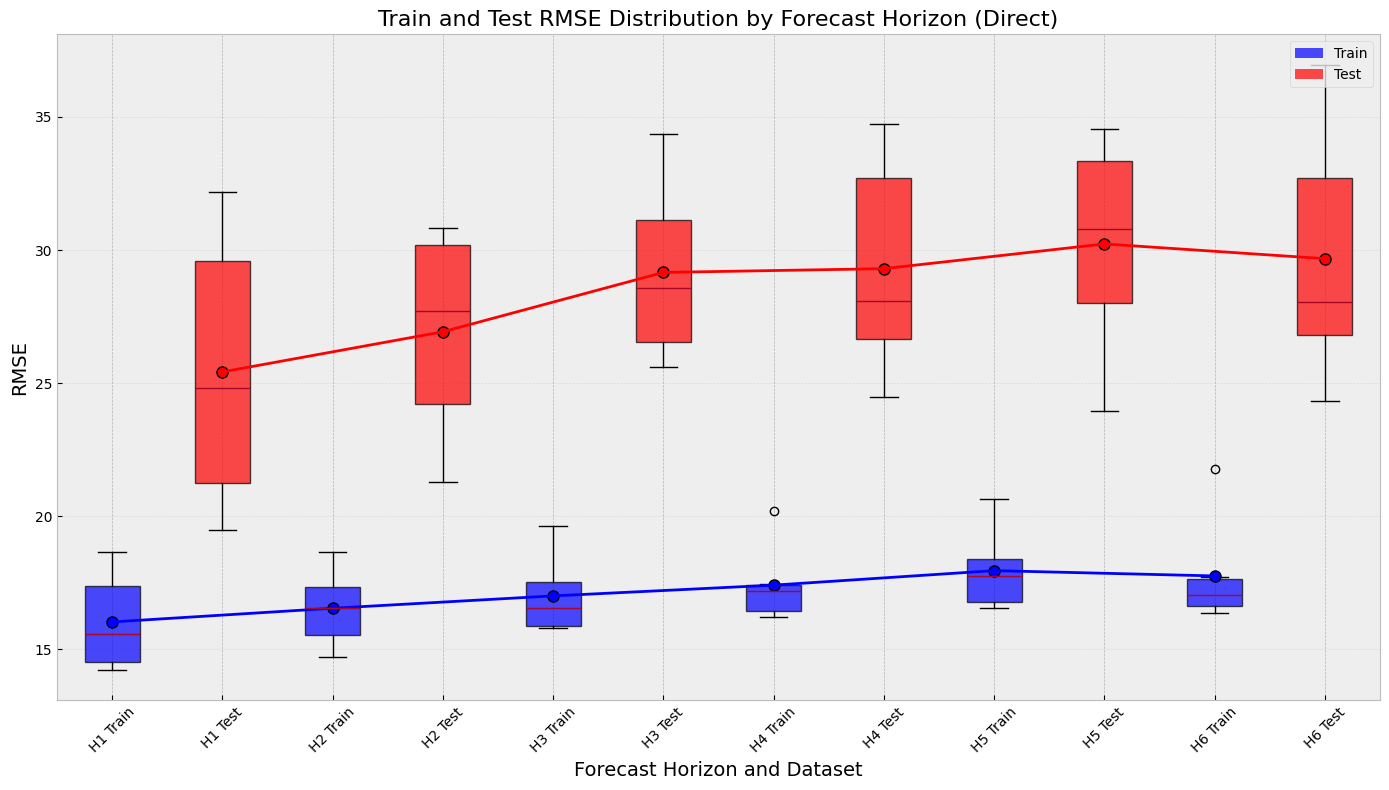


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 29.6967, Std Test RMSE 4.7287
  Time Steps 120: Mean Test RMSE 28.4602, Std Test RMSE 3.1824
  Time Steps 240: Mean Test RMSE 27.2093, Std Test RMSE 4.4987


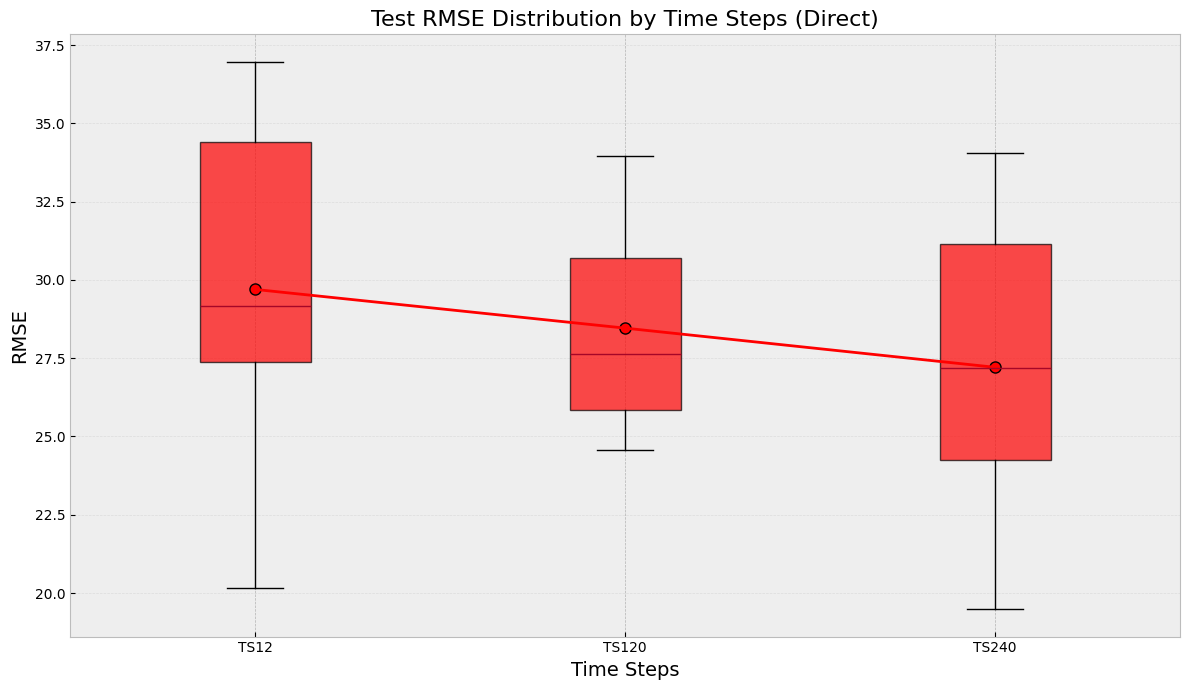


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.2263, Test RMSE 19.4835
Horizon 2: Best for H2 with Train RMSE 14.7277, Test RMSE 21.2720
Horizon 3: Best for H3 with Train RMSE 15.8006, Test RMSE 25.6058
Horizon 4: Best for H4 with Train RMSE 16.2039, Test RMSE 24.4834
Horizon 5: Best for H5 with Train RMSE 16.5474, Test RMSE 23.9487
Horizon 6: Best for H6 with Train RMSE 16.6053, Test RMSE 24.3360
--------------------------------------------------


In [32]:
print("Testing LSTM Direct:")
results_lstm_direct = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_lstm_model,
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=False,
    base_name="lstm"
)

The direct approach performs similarly to the recursive one but it slightly outperforms it in most of the cases suggesting that feeding the model in a recursive manner performs similarly.
There is a trade-off between the two approaches, with the direct method being more efficient in terms of computation while the recursive method may capture temporal dependencies better. Moreover, there is tendecy for the model to perform better with more training data, indicating that it benefits from larger datasets.

## Task 5.5: Build GRU model architecture

In [33]:
def build_gru_model(input_shape, units=50, dropout=0.2, filters=32, kernel_size=3, pool_size=2, output_units=1):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        Dropout(dropout),
        GRU(units, activation='tanh'),
        LayerNormalization(),
        Dropout(dropout),
        Dense(output_units)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['r2_score'])
    return model

## Task 5.6: Train GRU model for multi-step prediction - Recursive approach

Testing GRU recursive:
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.5992, Test RMSE: 21.1227
Forecast Horizon: 1, Time Steps: 12, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 19.2548, Test RMSE: 33.4745
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.3319, Test RMSE: 20.6129
Forecast Horizon: 1, Time Steps: 120, Recursive: True
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 17.1800, Test RMSE: 30.3492
Forecast Horizon: 1, Time Steps: 240, Recursive: True
Model Params: {'units': 64, 'dropout': 0.3, '

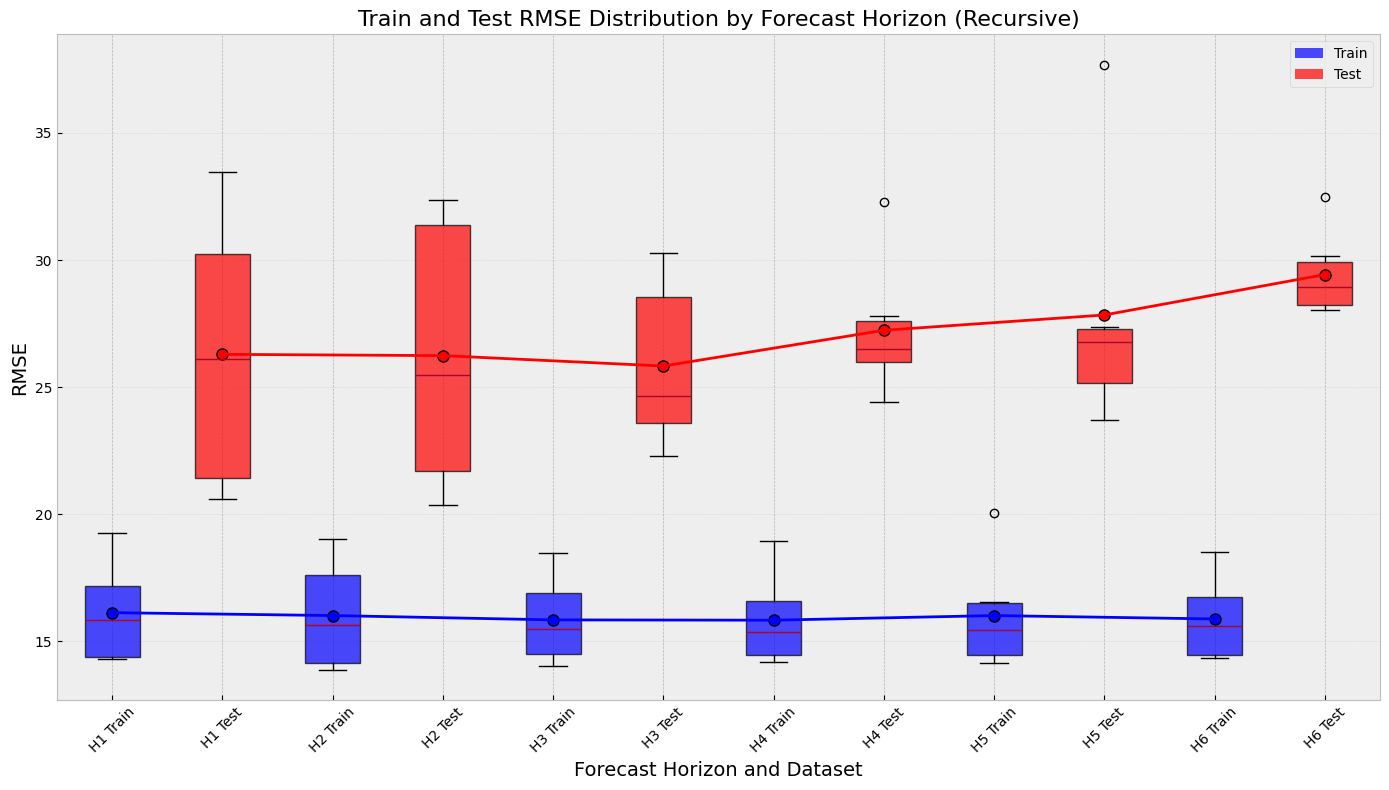


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 28.8468, Std Test RMSE 5.0538
  Time Steps 120: Mean Test RMSE 26.3216, Std Test RMSE 3.1003
  Time Steps 240: Mean Test RMSE 26.2620, Std Test RMSE 3.2308


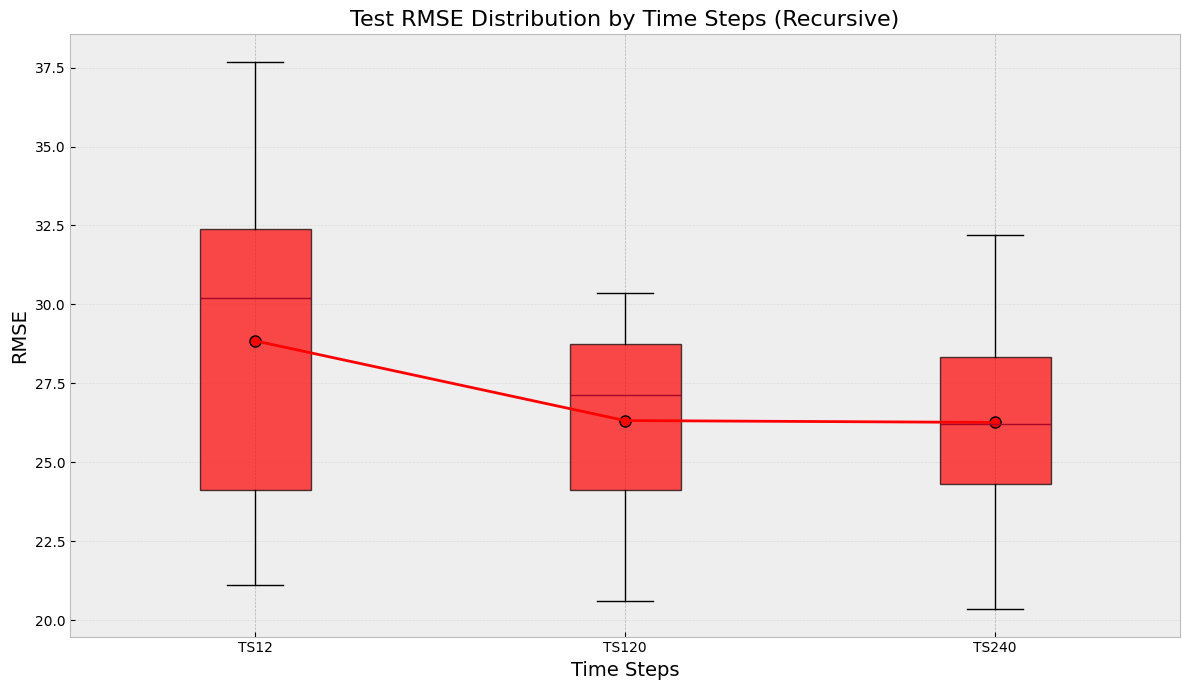


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.3319, Test RMSE 20.6129
Horizon 2: Best for H2 with Train RMSE 13.8707, Test RMSE 20.3457
Horizon 3: Best for H3 with Train RMSE 14.0429, Test RMSE 22.3071
Horizon 4: Best for H4 with Train RMSE 14.4207, Test RMSE 24.3984
Horizon 5: Best for H5 with Train RMSE 16.3738, Test RMSE 23.7003
Horizon 6: Best for H6 with Train RMSE 14.4447, Test RMSE 28.0466
--------------------------------------------------


In [34]:
print("Testing GRU recursive:")
results_gru_recursive = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_gru_model,
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=True,
    base_name="gru"
)

The gru model performs simlarly to the lstm model but it is slightly worse in most of the cases. The performance is consistent across different forecast horizons and training data lengths, showing similar generalization capabilities as the lstm model. As the forecast horizon increases, the performance degrades slightly, which is expected.

## Task 5.7: Train GRU model for multi-step prediction - Direct approach

Testing GRU direct:
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.4513, Test RMSE: 20.5296
Forecast Horizon: 1, Time Steps: 12, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 19.1601, Test RMSE: 33.2437
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3, 'filters': 64, 'kernel_size': 3, 'pool_size': 2, 'epochs': 100, 'batch_size': 16}
Train RMSE: 14.5350, Test RMSE: 22.9454
Forecast Horizon: 1, Time Steps: 120, Recursive: False
Model Params: {'units': 50, 'dropout': 0.4, 'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'epochs': 100, 'batch_size': 16}
Train RMSE: 17.1319, Test RMSE: 29.5556
Forecast Horizon: 1, Time Steps: 240, Recursive: False
Model Params: {'units': 64, 'dropout': 0.3,

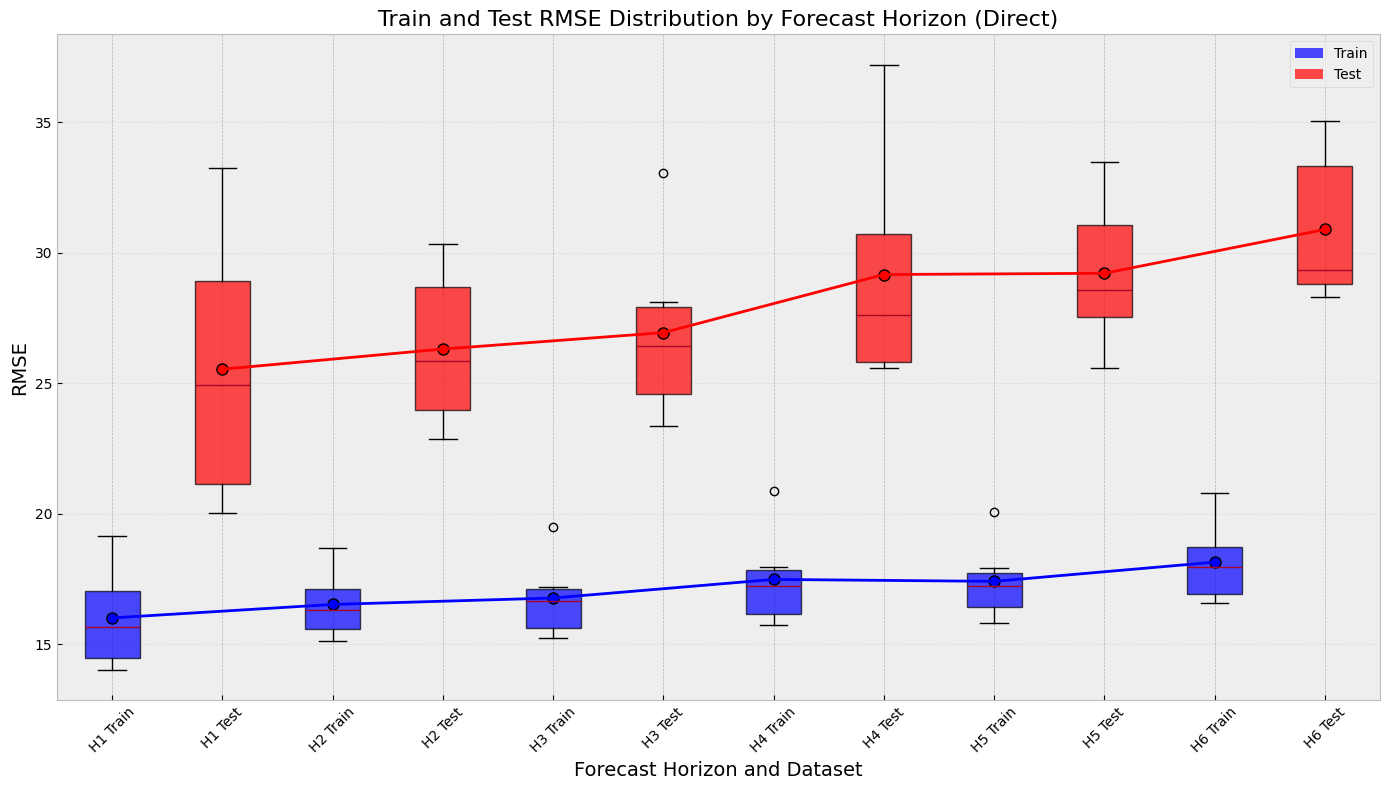


Comparison of Time Steps (Test RMSE):
  Time Steps 12: Mean Test RMSE 29.3355, Std Test RMSE 4.9491
  Time Steps 120: Mean Test RMSE 27.5120, Std Test RMSE 3.0115
  Time Steps 240: Mean Test RMSE 27.1726, Std Test RMSE 3.3048


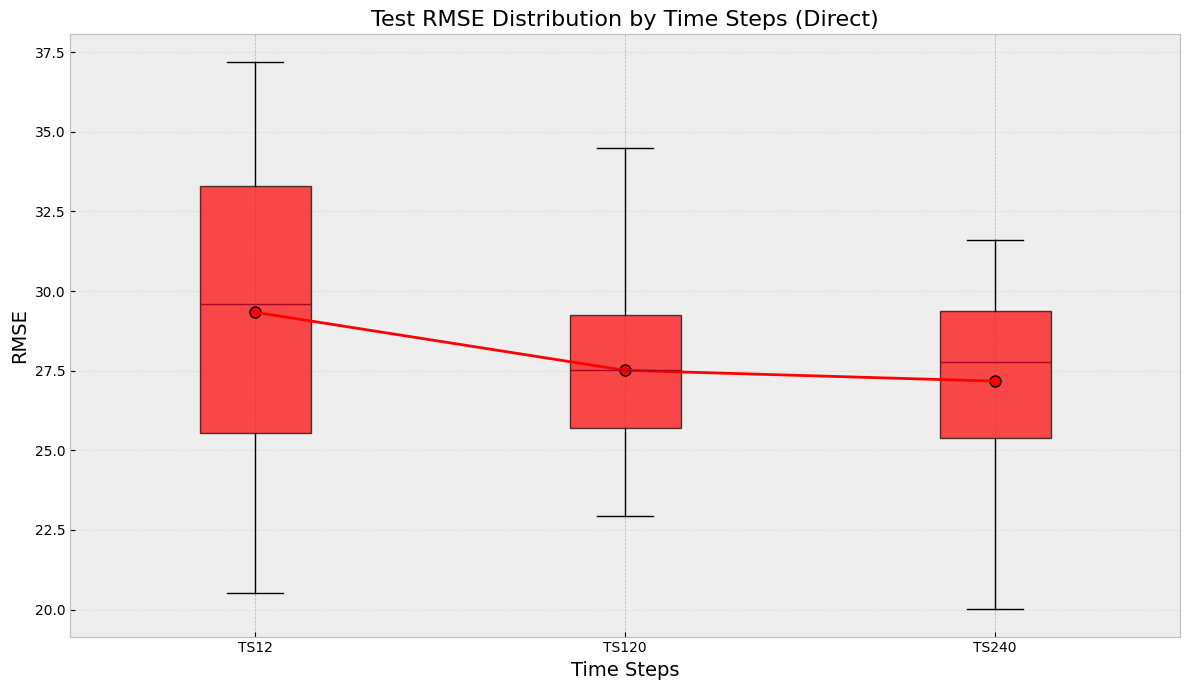


Best Model per Horizon:
--------------------------------------------------
Horizon 1: Best for H1 with Train RMSE 14.0156, Test RMSE 20.0114
Horizon 2: Best for H2 with Train RMSE 15.1403, Test RMSE 22.8498
Horizon 3: Best for H3 with Train RMSE 15.2534, Test RMSE 23.3468
Horizon 4: Best for H4 with Train RMSE 17.0424, Test RMSE 25.5687
Horizon 5: Best for H5 with Train RMSE 17.2261, Test RMSE 25.5849
Horizon 6: Best for H6 with Train RMSE 16.6171, Test RMSE 28.3191
--------------------------------------------------


In [35]:
print("Testing GRU direct:")
results_gru_direct = rolling_forecast_evaluation_multiple_steps(
    train_data=train_scaled, 
    test_data=test_scaled,
    time_steps_list=time_steps_list,
    model_builder=build_gru_model,
    param_list=rnn_param_list,
    scaler=scaler,
    forecast_horizon_list=forecast_horizon_list,
    recursive=False,
    base_name="gru"
    )


The gru model set in direct approach performs similarly to the recursive one but it slightly outperforms it in most of the cases suggesting that feeding the model in a recursive manner performs similarly.

## Task 5.9: Compare LSTM and GRU model performance

Using fixed evaluation window with time_steps=240 for fair comparison


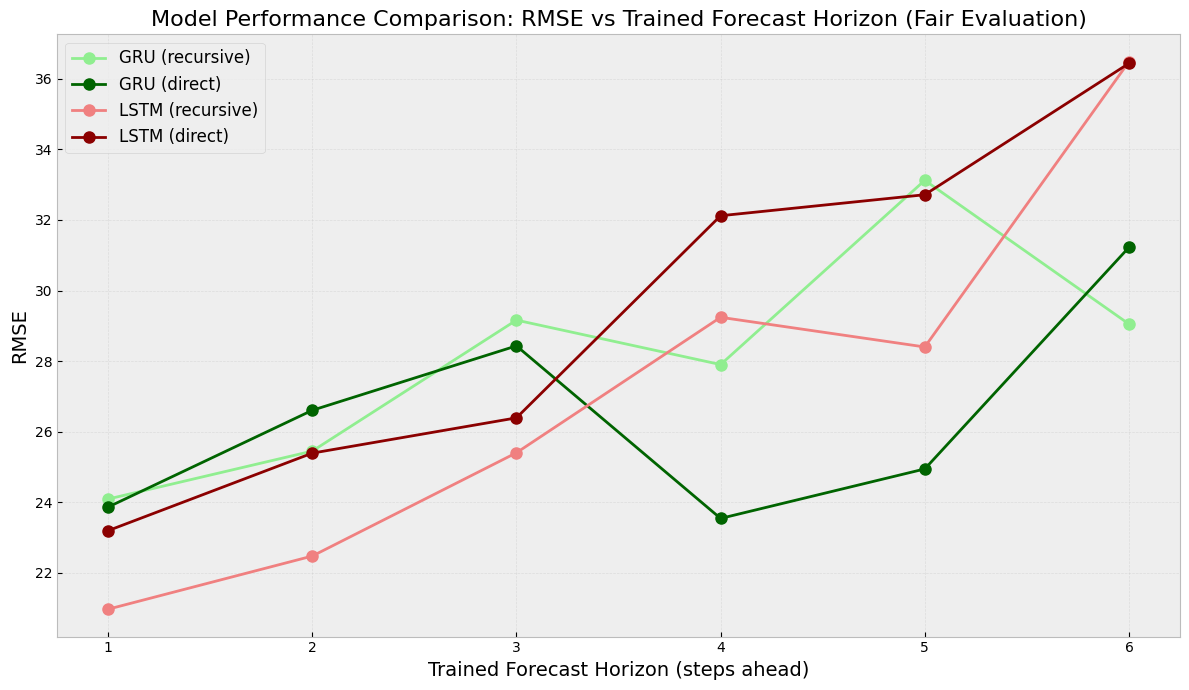


Model Performance Leaderboards (Fair Evaluation - All models tested on same window starting from index 240):
Leaderboard for Forecast Horizon 1:                 Leaderboard for Forecast Horizon 2:               
--------------------------------------------------  --------------------------------------------------
Rank  Model                     RMSE                Rank  Model                     RMSE              
--------------------------------------------------  --------------------------------------------------
1     LSTM (recursive)          20.9738             1     LSTM (recursive)          22.4794           
2     LSTM (direct)             23.1986             2     LSTM (direct)             25.3944           
3     GRU (direct)              23.8669             3     GRU (recursive)           25.4520           
4     GRU (recursive)           24.0939             4     GRU (direct)              26.6078           
--------------------------------------------------  --------------

In [47]:
# Comparison of gru and lstm with and without time distributed
compare_model_performance([
    results_gru_recursive['best_model_paths'],
    results_gru_direct['best_model_paths'],
    results_lstm_recursive['best_model_paths'],
    results_lstm_direct['best_model_paths']
], 
model_labels=[
    'GRU (recursive)',
    'GRU (direct)',
    'LSTM (recursive)',
    'LSTM (direct)'
],
forecast_horizon_list=forecast_horizon_list,
colors=['lightgreen', 'darkgreen', 'lightcoral', 'darkred'],
train_data=train_scaled,
test_data=test_scaled,
scaler=scaler)

The lstm recursive model lead the performance up until the third time horizon where the gru recursive model slightly outperforms it. After the fourth time horizon the GRU in direct mode starts to outperform all the other models. This might be due to the test set position in the time series where the gru model might be better at capturing certain patterns. We're comparing the best models obtained from the various configurations tested so in certain scenarios the gru might be better suited.
**Overall the recursive models seem to perform better than the direct ones except for the gru at high time horizons.**

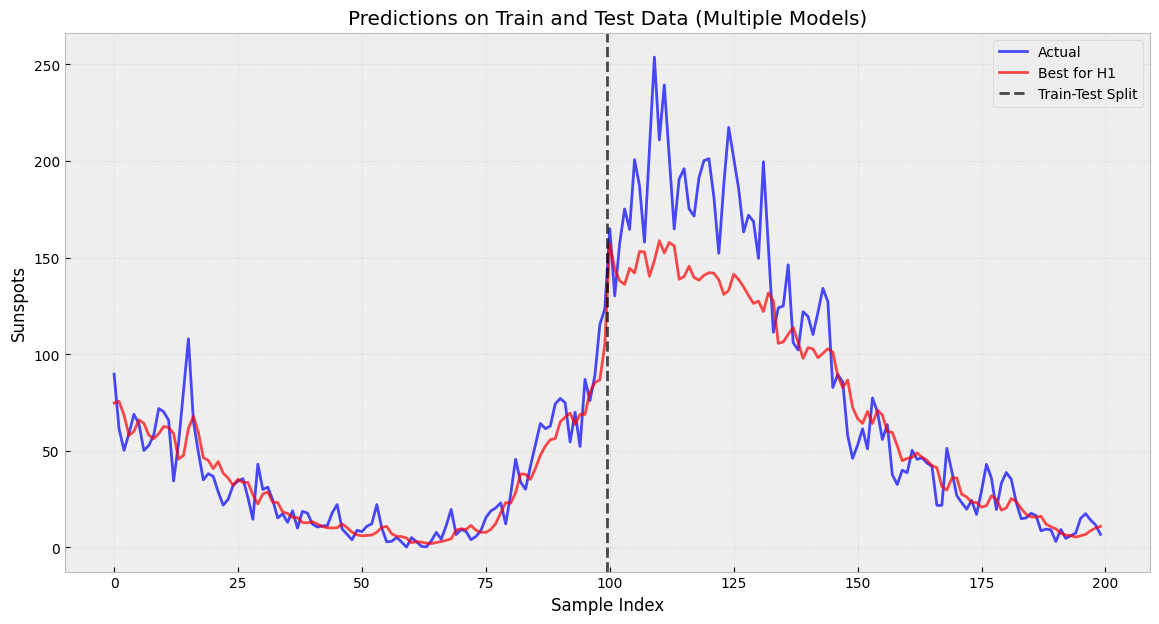

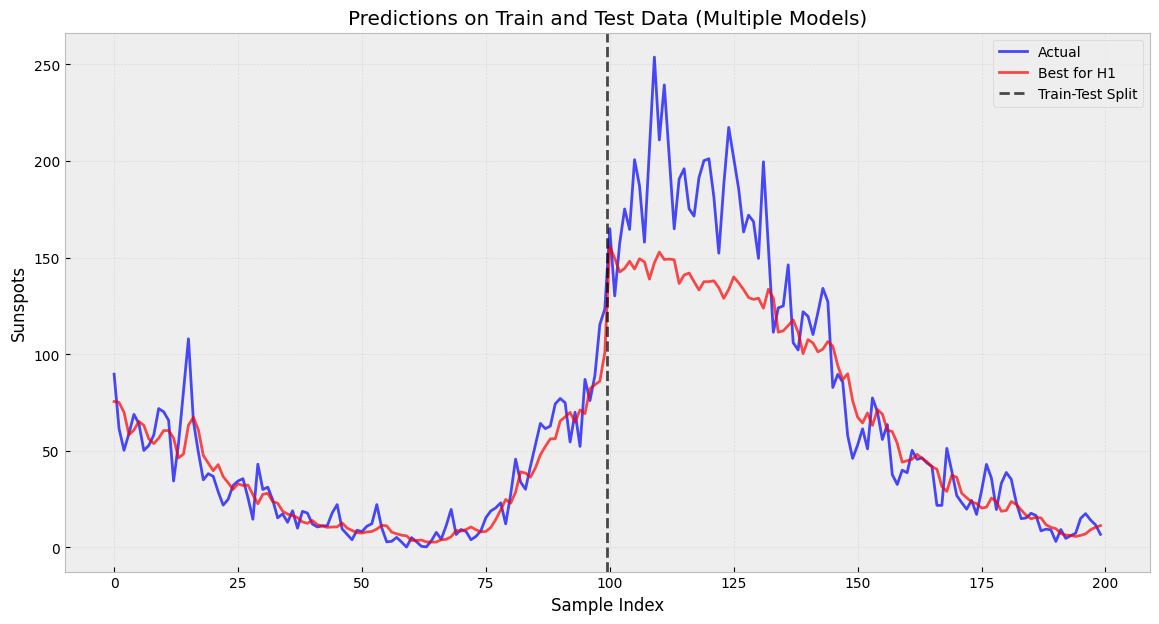

In [37]:
# Visualize the best LSTM model with its own time_steps
lstm_model_path = results_lstm_direct['best_model_paths'][0]
best_config_lstm = results_lstm_direct['best_configurations'][0]
time_steps_lstm = best_config_lstm['time_steps']
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = create_time_series_split(train_scaled, test_scaled, time_steps=time_steps_lstm, verbose=False, forecast_horizon=1)
visualize_predictions([lstm_model_path], X_test_lstm, y_test_lstm, scaler=scaler, X_train=X_train_lstm, y_train=y_train_lstm, n_train=100, n_test=100, labels=[results_lstm_direct['best_model_names'][0]])

# Visualize the best GRU model with its own time_steps
gru_model_path = results_gru_direct['best_model_paths'][0]
best_config_gru = results_gru_direct['best_configurations'][0]
time_steps_gru = best_config_gru['time_steps']
X_train_gru, y_train_gru, X_test_gru, y_test_gru = create_time_series_split(train_scaled, test_scaled, time_steps=time_steps_gru, verbose=False, forecast_horizon=1)
visualize_predictions([gru_model_path], X_test_gru, y_test_gru, scaler=scaler, X_train=X_train_gru, y_train=y_train_gru, n_train=100, n_test=100, labels=[results_gru_direct['best_model_names'][0]])

Both GRU and LSTM models perform similarly in terms of single step prediction as we can see from the plot above. Both follow the mean sunspot number trend quite closely except in certain volatile regions.

## Task 5.10: Final comprehensive comparison of all models

Using fixed evaluation window with time_steps=240 for fair comparison


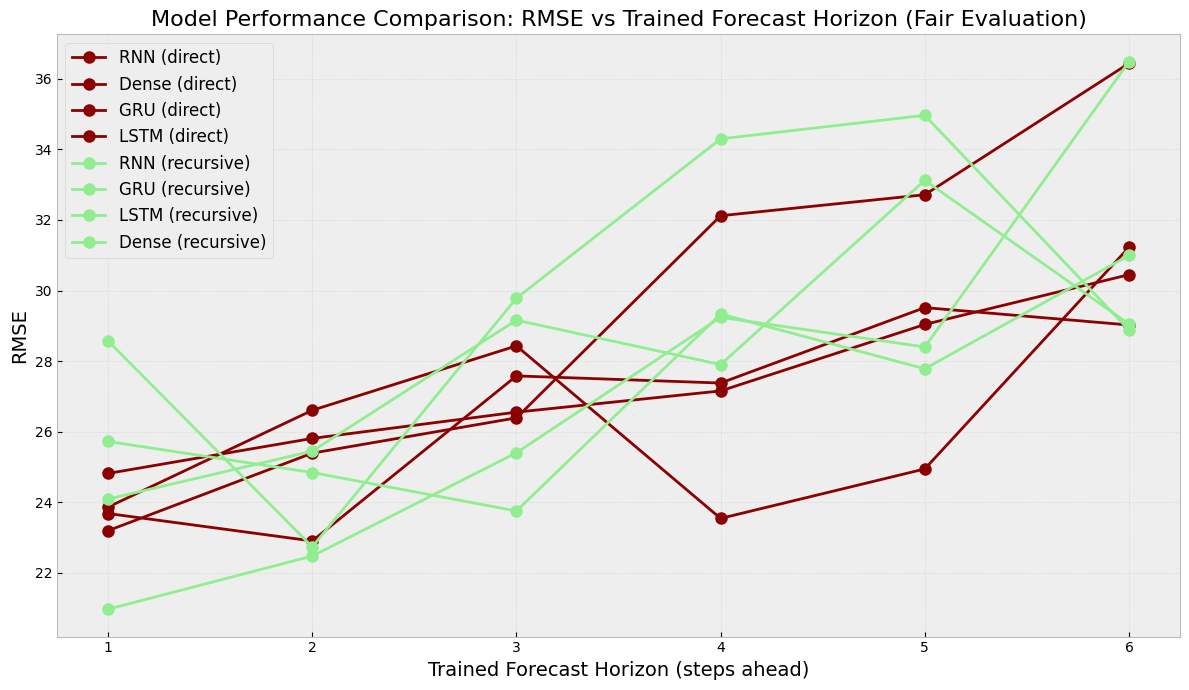


Model Performance Leaderboards (Fair Evaluation - All models tested on same window starting from index 240):
Leaderboard for Forecast Horizon 1:                 Leaderboard for Forecast Horizon 2:               
--------------------------------------------------  --------------------------------------------------
Rank  Model                     RMSE                Rank  Model                     RMSE              
--------------------------------------------------  --------------------------------------------------
1     LSTM (recursive)          20.9738             1     LSTM (recursive)          22.4794           
2     LSTM (direct)             23.1986             2     Dense (recursive)         22.7405           
3     Dense (direct)            23.6842             3     Dense (direct)            22.9066           
4     GRU (direct)              23.8669             4     RNN (recursive)           24.8454           
5     GRU (recursive)           24.0939             5     LSTM (di

In [48]:
# final giga comparison of all models
compare_model_performance([
    results_rnn_direct['best_model_paths'],
    results_dense_direct['best_model_paths'],
    results_gru_direct['best_model_paths'],
    results_lstm_direct['best_model_paths'],
    results_rnn_recursive['best_model_paths'],
    results_gru_recursive['best_model_paths'],
    results_lstm_recursive['best_model_paths'],
    results_dense_recursive['best_model_paths']
], 
model_labels=[
    'RNN (direct)',
    'Dense (direct)',
    'GRU (direct)',
    'LSTM (direct)',
    'RNN (recursive)',
    'GRU (recursive)',
    'LSTM (recursive)',
    'Dense (recursive)'
],
forecast_horizon_list=forecast_horizon_list,
colors=['darkred', 'darkred', 'darkred', 'darkred', "lightgreen", 'lightgreen', 'lightgreen', 'lightgreen'],
train_data=train_scaled,
test_data=test_scaled,
scaler=scaler)
tf.keras.backend.clear_session()

## **Conclusion: Model Performance Analysis**

Based on the comprehensive leaderboards across all forecast horizons:

### **Key Findings:**

1. **LSTM (recursive) dominates short-term forecasting** (H1-H2) with consistently lowest RMSE
2. **GRU (direct) excels at longer horizons** (H4-H6), outperforming all other models
3. **Dense models underperform significantly** across all horizons, especially in recursive mode
4. **Performance degradation**: All models show increasing RMSE as forecast horizon increases (20-36 RMSE range)

### **Recursive vs Direct Approach Analysis:**

**Recursive Strategy:**
- **Advantages**: Better for short-term forecasting (H1-H2), captures temporal dependencies through iterative prediction
- **Disadvantages**: Error accumulation over longer horizons, computational overhead for multi-step predictions
- **Best performers**: LSTM and GRU recursive excel in H1-H3

**Direct Strategy:**
- **Advantages**: More stable for longer forecasting horizons, trains specifically for target horizon, no error propagation
- **Disadvantages**: Requires separate models for each horizon, less temporal continuity
- **Best performers**: GRU direct dominates H4-H6

**Key Insight**: **Recursive approaches suffer from error accumulation** as predictions feed into subsequent steps, while **direct approaches maintain consistent performance** across longer horizons by training specifically for each target.

### **Best Strategy:**
- **Short-term (1-2 steps)**: Use **LSTM recursive** 
- **Long-term (4-6 steps)**: Use **GRU direct**
- **Avoid**: Dense recursive models (worst performers)

### **Overall Winner:**
**LSTM and GRU models** significantly outperform simpler architectures, with **GRU direct** showing the best stability across increasing forecast horizons.

**Recommendation**: Deploy GRU direct for robust multi-step forecasting applications.